In [2]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 

In [3]:
out_path = '/home/icn/Documents/raw_out/RF_32_4/'
BIDS_path = '/home/icn/Documents/BIDS/'

In [4]:
subject_exclude = ['002', '003', '011', '012', '015', '016']
subject_tf_usage = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014', '016']
#002 - DBS4011 - no locaization possible
#003 - DBS4020 - LEFT due to signal quality
#011 - DBS4037 - STN was not recorded
#012 - DBS4030 - GPi not STN 
#015 - DBS4065 - LEFT due to signal quality

In [5]:
# setup plot where STN and ECOG is visible 
faces = io.loadmat('faces.mat')
Vertices = io.loadmat('Vertices.mat')
grid = io.loadmat('grid.mat')['grid']
stn_surf = io.loadmat('STN_surf.mat')
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

In [6]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

In [7]:
def get_x_y_c(dict_ch, ind_, Con=True, return_z=False):
    
    channels = list(dict_ch.keys())
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    z_choord = np.zeros(len(ind_))
    c_ = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        z_choord[idx] = choord[2]
        
        #wähle den contralateralen channel aus
        mov_channels = dict_ch[channels[ind_ch]]['mov_ch']

        mov_idx = get_movement_idx(channels[ind_ch], mov_channels, Con)

        c_[idx] = dict_ch[channels[ind_ch]]["res_"+mov_channels[mov_idx]]["R2"]
    if return_z is True:
        return x_choord, y_choord, z_choord, c_
    return x_choord, y_choord, c_

In [8]:
subject_id = []
for patient_test in range(17):
    if patient_test < 10:
        subject_id.append(str('00') + str(patient_test))
    else:
        subject_id.append(str('0') + str(patient_test))


In [9]:
def get_movement_idx(ch, mov_channels, Con=True):
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

### Plot all Electrodes

In [9]:
def plot_all_electrodes(out_path='/home/icn/Documents/raw_out/LM_100ms/', Con=True):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    
    rows=6; columns = 4
    
    fig, axes = plt.subplots(rows,columns, facecolor=(1,1,1), gridspec_kw={'height_ratios': [height_ECOG, height_STN]*3}, \
                             figsize=(17,17))#, dpi=700)
    x_cnt_ECOG, y_cnt_ECOG, x_cnt_STN, y_cnt_STN = 0,0,0,1

    for sub_idx, subject_id_ in enumerate(subject_id):    
        if subject_id_ in subject_exclude: 
                continue
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
        channels = list(dict_ch.keys())
        ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
        ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]


        axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x_ecog, y_ecog, c="gray", s=0.0001)
        axes[y_cnt_ECOG, x_cnt_ECOG].set_title('sub'+subject_id_, color='black')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_axis_off()
        x,y,c = get_x_y_c(dict_ch, ind_ECOG, Con)
        c = np.ones(x.shape[0])
        if subject_id_ == '001' or subject_id_ == '006':
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=2, cmap='hot')
        else:
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=15, cmap='hot')
        cbar_ecog = fig.colorbar(pos_ecog, ax=axes[y_cnt_ECOG, x_cnt_ECOG]); pos_ecog.set_clim(1,1.4); cbar_ecog.remove()

        pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x_stn, y_stn, c="gray", s=0.0001)

        if subject_id_ not in ['012', '003']:

            x,y,c = get_x_y_c(dict_ch, ind_STN, Con)
            c = np.ones(x.shape[0])
            if subject_id_ == '016':
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x, y, c=c, s=10, cmap='hot')
            else:
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x, y, c=c, s=15, cmap='hot')
        cbar_stn = fig.colorbar(pos_stn, ax=axes[y_cnt_STN, x_cnt_STN]); pos_stn.set_clim(1,1.4); cbar_stn.remove()

        axes[y_cnt_STN, x_cnt_STN].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_STN, x_cnt_STN].set_facecolor((1,1,1))
        axes[y_cnt_STN, x_cnt_STN].set_axis_off()
        axes[y_cnt_ECOG, x_cnt_ECOG].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_facecolor((1,1,1))

        x_cnt_ECOG = x_cnt_ECOG + 1
        x_cnt_STN = x_cnt_ECOG

        if x_cnt_ECOG == 4:
            y_cnt_ECOG = y_cnt_ECOG + 2
            y_cnt_STN = y_cnt_ECOG + 1
            x_cnt_ECOG, x_cnt_STN = 0, 0

    axes[4, 3].set_facecolor((1,1,1)); axes[4, 3].set_axis_off()
    axes[5, 3].set_facecolor((1,1,1)); axes[5, 3].set_axis_off()
    #axes[6, 3].set_facecolor((1,1,1)); axes[6, 3].set_axis_off()
    #axes[7, 1].set_facecolor((1,1,1)); axes[7, 1].set_axis_off()
    #axes[7, 2].set_facecolor((1,1,1)); axes[7, 2].set_axis_off()
    #axes[7, 3].set_facecolor((1,1,1)); axes[7, 3].set_axis_off()

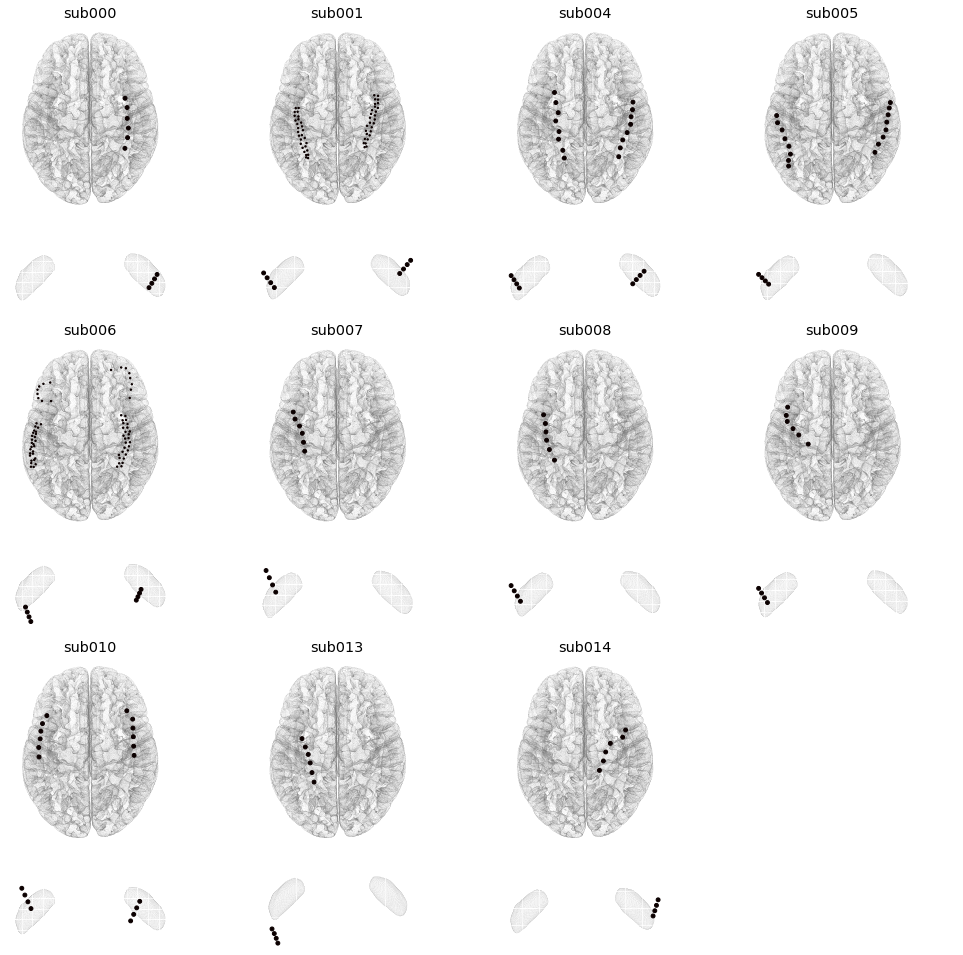

In [48]:
plot_all_electrodes()

### Plot all inividual Patients

In [10]:
#4037, 4065, 4011 KEINE STN DATEN 
#011, 015, 002
def plot_all_patients(out_path='/home/icn/Documents/raw_out/LM_100ms/', Con=True):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    rows=6; columns = 4
    fig, axes = plt.subplots(rows,columns, facecolor=(0,0,0), gridspec_kw={'height_ratios': [height_ECOG, height_STN]*3}, \
                             figsize=(17,17))#, dpi=700)
    x_cnt_ECOG, y_cnt_ECOG, x_cnt_STN, y_cnt_STN = 0,0,0,1

    for sub_idx, subject_id_ in enumerate(subject_id):    
        if subject_id_ in subject_exclude: 
            continue
        if subject_id_ == '016' and Con is False:
            axes[y_cnt_STN, x_cnt_STN].axes.set_aspect('equal', anchor='C')
            axes[y_cnt_STN, x_cnt_STN].set_facecolor((0,0,0))
            axes[y_cnt_ECOG, x_cnt_ECOG].axes.set_aspect('equal', anchor='C')
            axes[y_cnt_ECOG, x_cnt_ECOG].set_facecolor((0,0,0))
            continue
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
        channels = list(dict_ch.keys())
        ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
        ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]


        axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x_ecog, y_ecog, c="gray", s=0.0001)
        axes[y_cnt_ECOG, x_cnt_ECOG].set_title('sub'+subject_id_, color='white')
        x,y,c = get_x_y_c(dict_ch, ind_ECOG, Con)
        if subject_id_ == '001' or subject_id_ == '006':
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=5)
        else:
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=15)

        cbar_ecog = fig.colorbar(pos_ecog, ax=axes[y_cnt_ECOG, x_cnt_ECOG]); pos_ecog.set_clim(0,0.5); cbar_ecog.remove()

        pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x_stn, y_stn, c="gray", s=0.0001)

        if subject_id_ not in ['012', '003']:

            x,y,c = get_x_y_c(dict_ch, ind_STN, Con)

            if subject_id_ == '016':
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x, y, c=c, s=5)
            else:
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x, y, c=c, s=15)
 
        cbar_stn = fig.colorbar(pos_stn, ax=axes[y_cnt_STN, x_cnt_STN]); pos_stn.set_clim(0,0.5); cbar_stn.remove()

        axes[y_cnt_STN, x_cnt_STN].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_STN, x_cnt_STN].set_facecolor((0,0,0))
        axes[y_cnt_ECOG, x_cnt_ECOG].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_facecolor((0,0,0))

        x_cnt_ECOG = x_cnt_ECOG + 1
        x_cnt_STN = x_cnt_ECOG

        if x_cnt_ECOG == 4:
            y_cnt_ECOG = y_cnt_ECOG + 2
            y_cnt_STN = y_cnt_ECOG + 1
            x_cnt_ECOG, x_cnt_STN = 0, 0
    
    axes[4, 3].set_facecolor((0,0,0)); axes[4, 3].set_axis_off()
    axes[5, 3].set_facecolor((0,0,0)); axes[5, 3].set_axis_off()
    #axes[6, 1].set_facecolor((0,0,0)); axes[6, 1].set_axis_off()
    #axes[6, 2].set_facecolor((0,0,0)); axes[6, 2].set_axis_off()
    #axes[6, 3].set_facecolor((0,0,0)); axes[6, 3].set_axis_off()
    #axes[7, 1].set_facecolor((0,0,0)); axes[7, 1].set_axis_off()
    #axes[7, 2].set_facecolor((0,0,0)); axes[7, 2].set_axis_off()
    #axes[7, 3].set_facecolor((0,0,0)); axes[7, 3].set_axis_off()

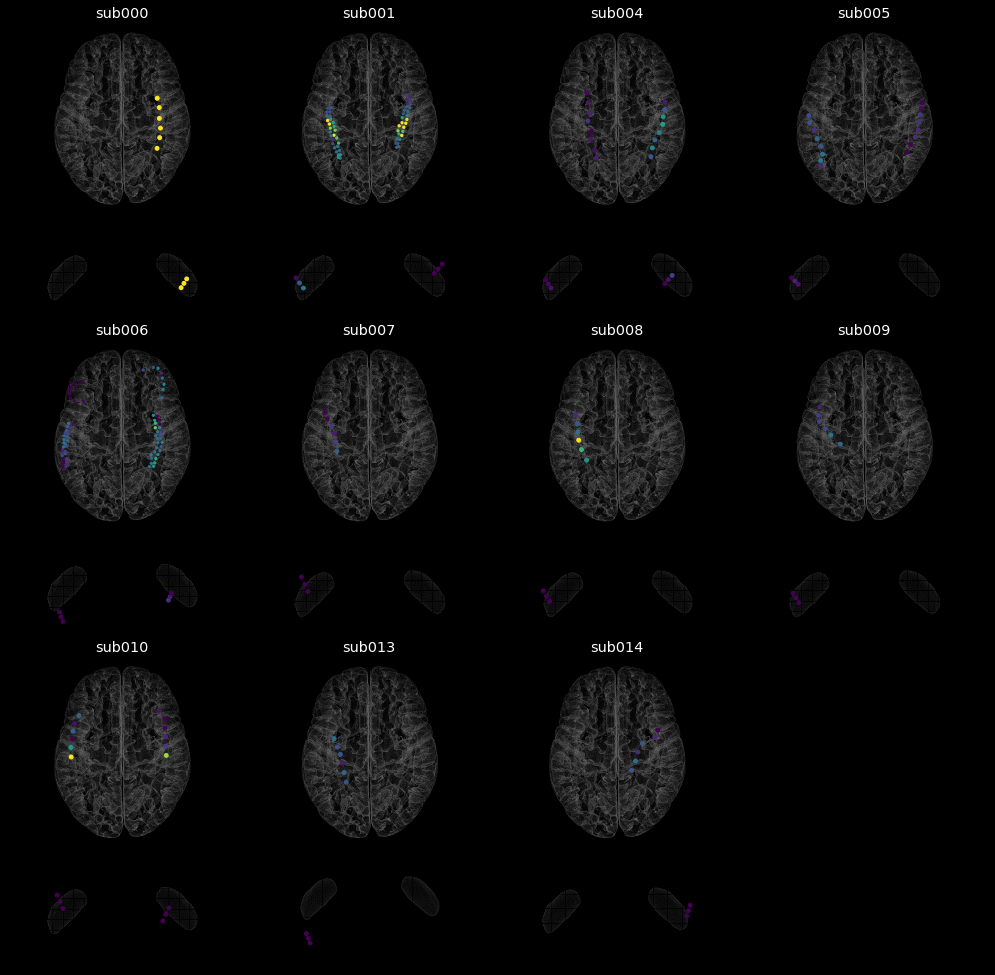

In [50]:
plot_all_patients('/home/icn/Documents/raw_out/RF_32_4_with_AUC/', True)

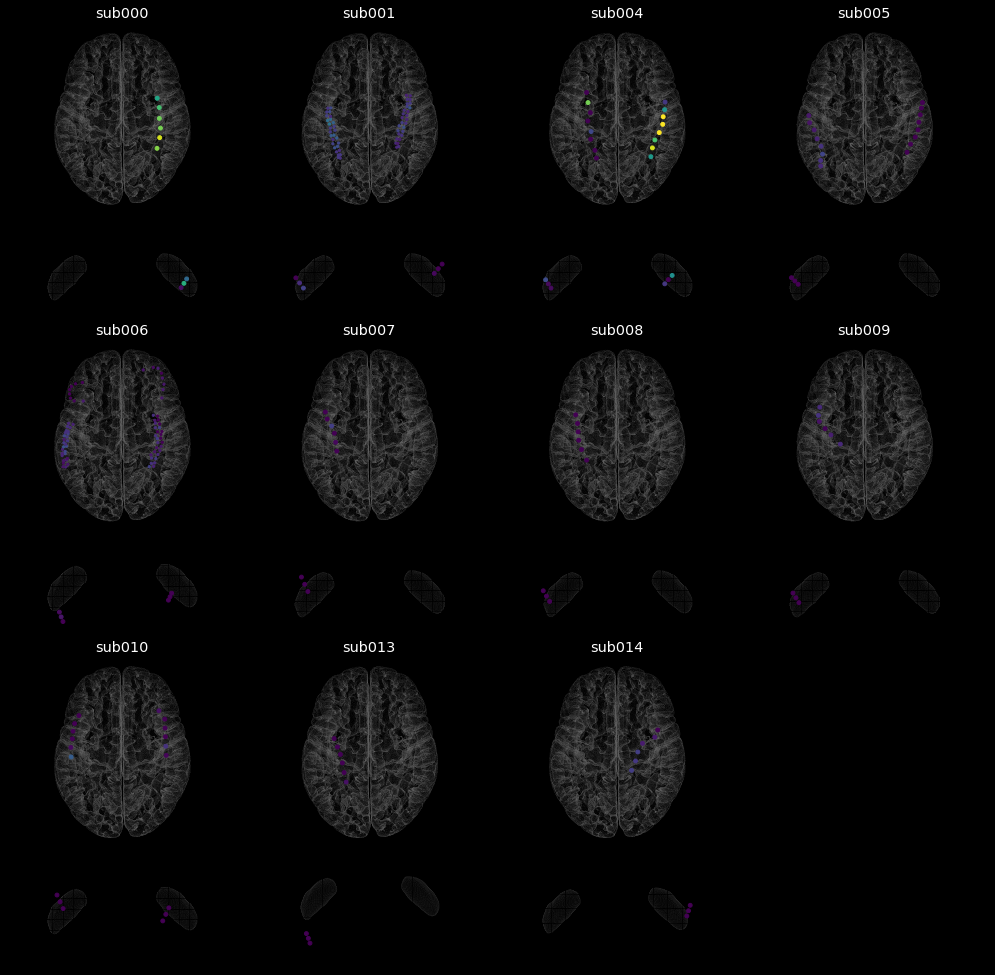

In [54]:
plot_all_patients('/home/icn/Documents/raw_out/RF_32_4_with_AUC/', False)

### plot best vals all on one plot

In [11]:
def plot_all_in_one(out_path='/home/icn/Documents/raw_out/LM_100ms/'):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    fig, axes = plt.subplots(2,2, facecolor=(0,0,0), gridspec_kw={'height_ratios': [height_ECOG, height_STN]}, \
                             figsize=(14,9))#, dpi=300)
    for idx in range(2):
        axes[0, idx].scatter(x_ecog, y_ecog, c="gray", s=0.001)
        axes[1, idx].scatter(x_stn, y_stn, c="gray", s=0.001)
        for sub_idx, subject_id_ in enumerate(subject_id[:-1]):  
            if subject_id_ in subject_exclude: 
                continue
            with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
                dict_ch = json.load(fp)
            channels = list(dict_ch.keys())
            ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
            ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]
            if idx == 0:
                x,y,c = get_x_y_c(dict_ch, ind_ECOG, Con=True)
            else:
                x,y,c = get_x_y_c(dict_ch, ind_ECOG, Con=False)
            pos_ecog = axes[0, idx].scatter(x, y, c=c, s=10, alpha=0.8)
            if idx == 0:
                x,y,c = get_x_y_c(dict_ch, ind_STN, Con=True)
            else:
                x,y,c = get_x_y_c(dict_ch, ind_STN, Con=False)
            if subject_id_ not in ['012', '003']:
                pos_stn = axes[1, idx].scatter(x, y, c=c, s=10, alpha=0.8)
                cbar_stn = fig.colorbar(pos_stn, ax=axes[1, idx]); pos_stn.set_clim(0,0.5); cbar_stn.remove()

            cbar_ecog = fig.colorbar(pos_ecog, ax=axes[0, idx]); pos_ecog.set_clim(0,0.5); cbar_ecog.remove()

        if idx == 1:
            cbar_ecog = fig.colorbar(pos_ecog, ax=axes[0, idx]); pos_ecog.set_clim(0,0.5); 
            cbar_ecog.set_label('R²', color="white")
            cbar_ecog.ax.tick_params(axis='y', color='white')
            cbar_ecog.ax.set_yticklabels(labels=np.round(cbar_ecog.get_ticks(),2),color='white')
            cbar_ecog.outline.set_edgecolor('white')
        if idx == 0:
            axes[0, idx].set_title('contralateral performance', color='white')
        else:
            axes[0, idx].set_title('ipsilateral performance', color='white')
        axes[0, idx].axes.set_aspect('equal', anchor='C')
        axes[0, idx].set_facecolor((0,0,0))
        axes[1, idx].axes.set_aspect('equal', anchor='C')
        axes[1, idx].set_facecolor((0,0,0))


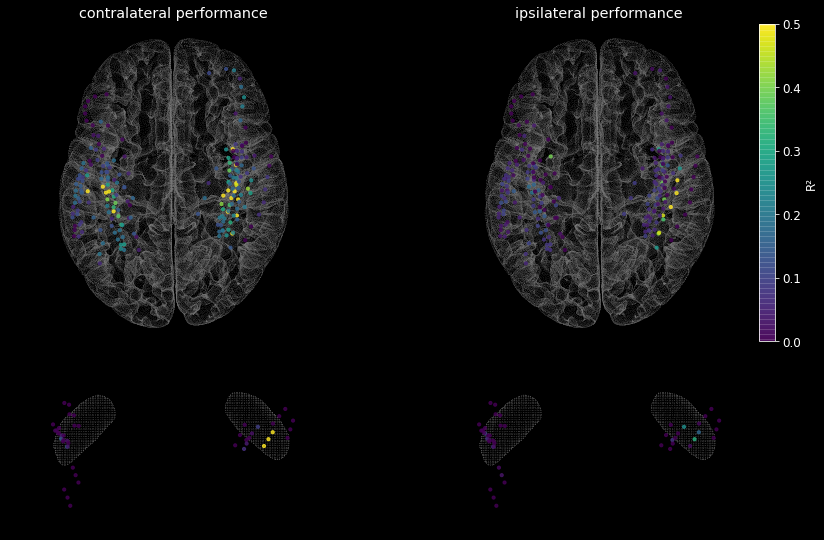

In [52]:
plot_all_in_one('/home/icn/Documents/raw_out/RF_32_4_with_AUC/')

In [10]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False, measure='R2'):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        if ECOG is True and 'STN' in ch:
            continue
        elif ECOG is False and 'ECOG' in ch:
            continue
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]][measure]
        mov_idx_[counter_ch] = mov_idx
        counter_ch += 1

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, best_acc, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    return best_ch, best_acc, best_weights

In [11]:
def my_boxplot_weights(alpha_con, alpha_ips):
    data_a = alpha_con
    data_b = alpha_ips
    ticks = [str(i) for i in range(8)]

    bpl = plt.boxplot(data_a, positions=np.array(range(8))*2.0-0.4, widths=0.6, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(8))*2.0+0.4, widths=0.6, patch_artist=True)
    set_box_color(bpl, 'red') # '#910707' colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='contralateral')
    plt.plot([], c='blue', label='ipsilateral')
    plt.xticks(range(0, len(ticks) * 2, 2), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('patient')
    plt.tight_layout()

def set_box_color(bp, color):
    #plt.setp(bp['boxes'], color='black')
    #plt.setp(bp['whiskers'], color='black')
    #plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='black')
    l_ = []
    l_.append(color)
    l_ = l_*len(bp['boxes']) 
    for patch, color_ in zip(bp['boxes'], l_):
        patch.set_facecolor(color_)
    

In [12]:
def get_best_weights_single_time_point(out_path):
    weights_ecog_con = []; weights_ecog_ips = []
    weights_stn_con = []; weights_stn_ips = []

    for sub_idx, subject_id_ in enumerate(subject_id):
        if subject_id_ in subject_exclude: 
            continue

        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        weights_ecog_con.append(get_best(dict_ch, Con=True, ECOG=True)[2])
        weights_ecog_ips.append(get_best(dict_ch, Con=False, ECOG=True)[2])
        try:
            weights_stn_con.append(get_best(dict_ch, Con=True, ECOG=False)[2])
            weights_stn_ips.append(get_best(dict_ch, Con=False, ECOG=False)[2])
        except ValueError:  # no STN here
            pass
    return np.array(weights_ecog_con), np.array(weights_ecog_ips), np.array(weights_stn_con), np.array(weights_stn_ips)


#### plot best weights single timepoints

In [13]:
def plot_single_time_point_weights(out_path='/home/icn/Documents/raw_out/LM_100ms/'):
    
    weights_ecog_con, weights_ecog_ips, weights_stn_con, weights_stn_ips = get_best_weights_single_time_point(out_path)
    
    plt.figure(figsize=(10, 4), dpi=300)
    plt.subplot(1,2,1)
    my_boxplot_weights(weights_ecog_con,  weights_ecog_ips)
    plt.legend()
    plt.ylabel('Weights')
    plt.ylim(-1,1)
    plt.title('ECoG best channel weight contributions')
    plt.xlabel('Frequency bands'); #plt.grid(True)
    

    plt.subplot(1,2,2)
    my_boxplot_weights(weights_stn_con,  weights_stn_ips)
    plt.legend(loc='upper left')
    plt.title('STN best channel weight contributions')
    plt.ylim(-1,1)
    plt.tight_layout()
    plt.xlabel('Frequency bands'); #plt.grid(True)
    plt.show()

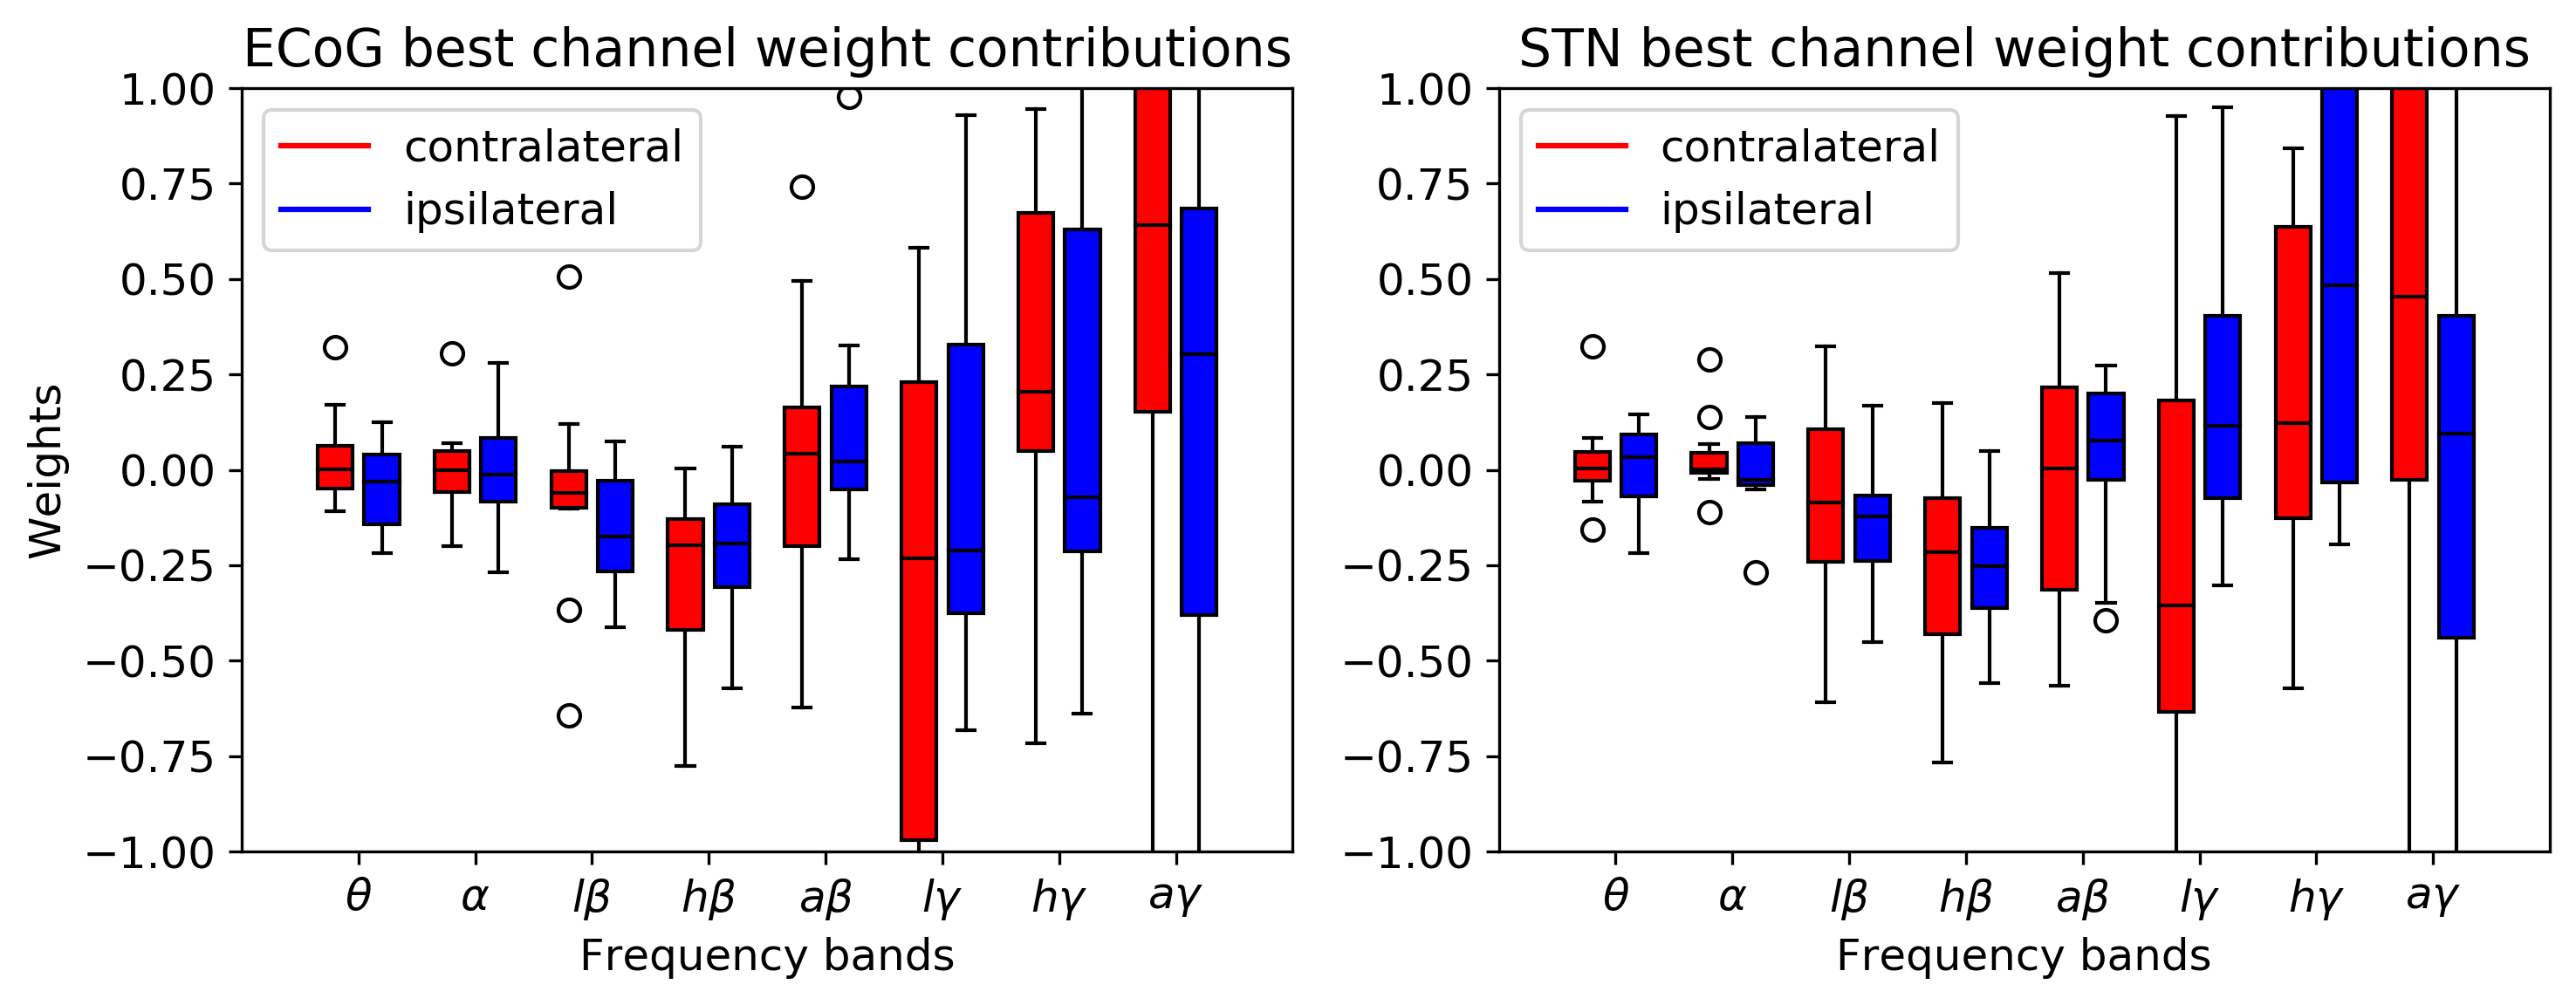

In [20]:
#plot_single_time_point_weights(out_path='/home/icn/Documents/raw_out/LM_class_100ms/')
plot_single_time_point_weights(out_path='/home/icn/Documents/raw_out/LM_100ms/')

In [22]:
weights_ecog_con, weights_ecog_ips, weights_stn_con, weights_stn_ips = get_best_weights_single_time_point(out_path='/home/icn/Documents/raw_out/LM_100ms/')

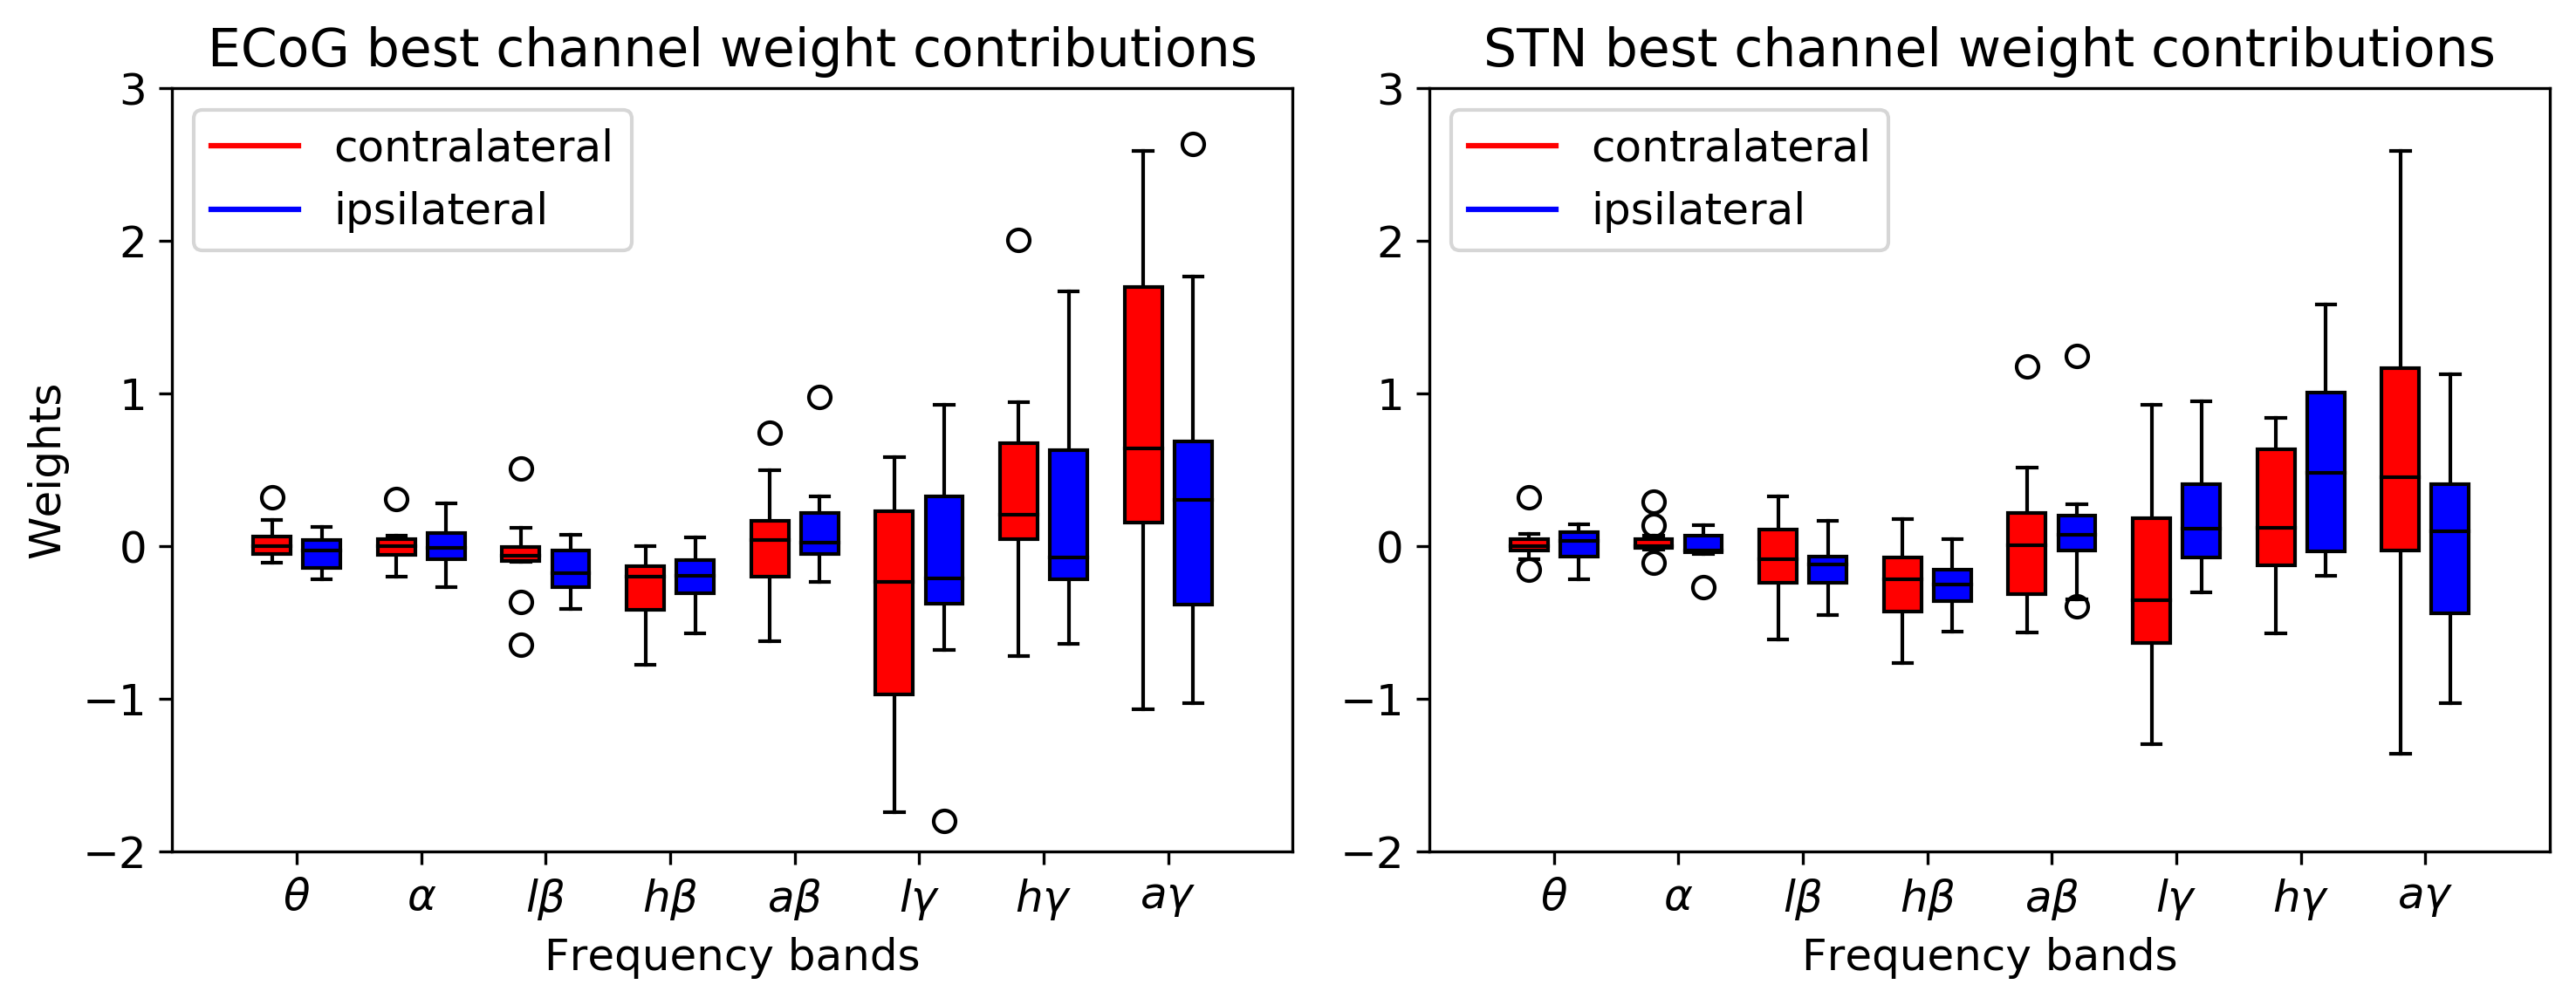

In [26]:
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1,2,1)
my_boxplot_weights(weights_ecog_con,  weights_ecog_ips)
plt.legend()
plt.ylabel('Weights')
plt.ylim(-2,3)
plt.title('ECoG best channel weight contributions')
plt.xlabel('Frequency bands'); #plt.grid(True)


plt.subplot(1,2,2)
my_boxplot_weights(weights_stn_con,  weights_stn_ips)
plt.legend(loc='upper left')
plt.title('STN best channel weight contributions')
plt.ylim(-2,3)
plt.tight_layout()
plt.xlabel('Frequency bands'); #plt.grid(True)
plt.show()

#### plot best weights 10 timepoints

In [11]:
def plot_weights(arr, title_, cmap=False):
    plt.imshow(arr) #cmap='seismic')
    plt.clim(-0.5, 0.5)
    plt.xticks(np.arange(9), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700'], 
              rotation=45, horizontalalignment = 'center')
    plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.xlabel('Time [ms]')
    #cbar = plt.colorbar()
    #cbar.set_label('Weights')
    plt.clim(-0.5,0.5)
    plt.xlim(-0.5, 6.5)
    plt.ylim(-0.5, 7.5)
    plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.title(title_)

In [36]:
weights_ecog_con, weights_ecog_ips, weights_stn_con, weights_stn_ips = \
    get_best_weights_single_time_point(out_path='/home/icn/Documents/raw_out/LM_700ms/')

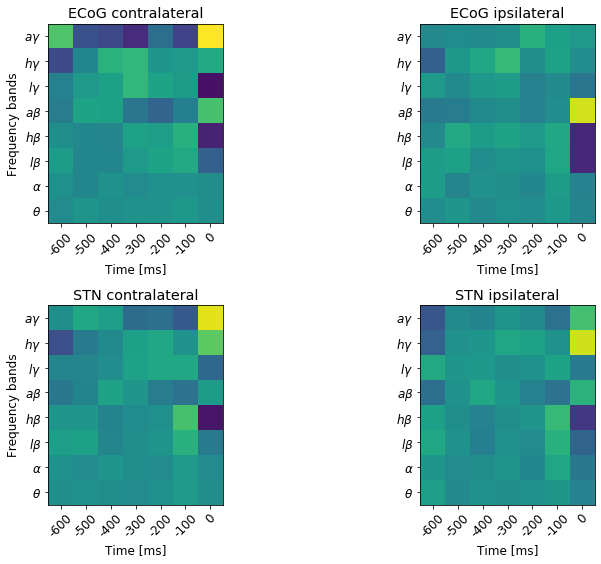

In [37]:
plt.figure(figsize=(12,8))#, dpi=300)
plt.subplot(2,2,1)
plot_weights(np.reshape(np.mean(weights_ecog_con, axis=0), (7,8)).T, 'ECoG contralateral'); plt.ylabel('Frequency bands')
plt.subplot(2,2,2)

plot_weights(np.reshape(np.mean(weights_ecog_ips, axis=0), (7,8)).T, 'ECoG ipsilateral'); plt.subplot(2,2,3)
plt.ylabel('Frequency bands')
plot_weights(np.reshape(np.mean(weights_stn_con, axis=0), (7,8)).T, 'STN contralateral'); plt.subplot(2,2,4)
plot_weights(np.reshape(np.mean(weights_stn_ips, axis=0), (7,8)).T, 'STN ipsilateral', True)
plt.tight_layout()

#### Plot here the best weights trained only for one time point

In [38]:
arr_ = np.zeros([4,10,8])
for time_shift in range(10):
    out_here = '/home/icn/Documents/raw_out/time_shift/LM_' + str(time_shift)+'/'
    weights_ecog_con, weights_ecog_ips, weights_stn_con, weights_stn_ips = \
        get_best_weights_single_time_point(out_here)
    arr_[0,time_shift,:] = np.mean(weights_ecog_con, axis=0)
    arr_[1,time_shift,:] = np.mean(weights_ecog_ips, axis=0)
    arr_[2,time_shift,:] = np.mean(weights_stn_con, axis=0)
    arr_[3,time_shift,:] = np.mean(weights_stn_ips, axis=0)

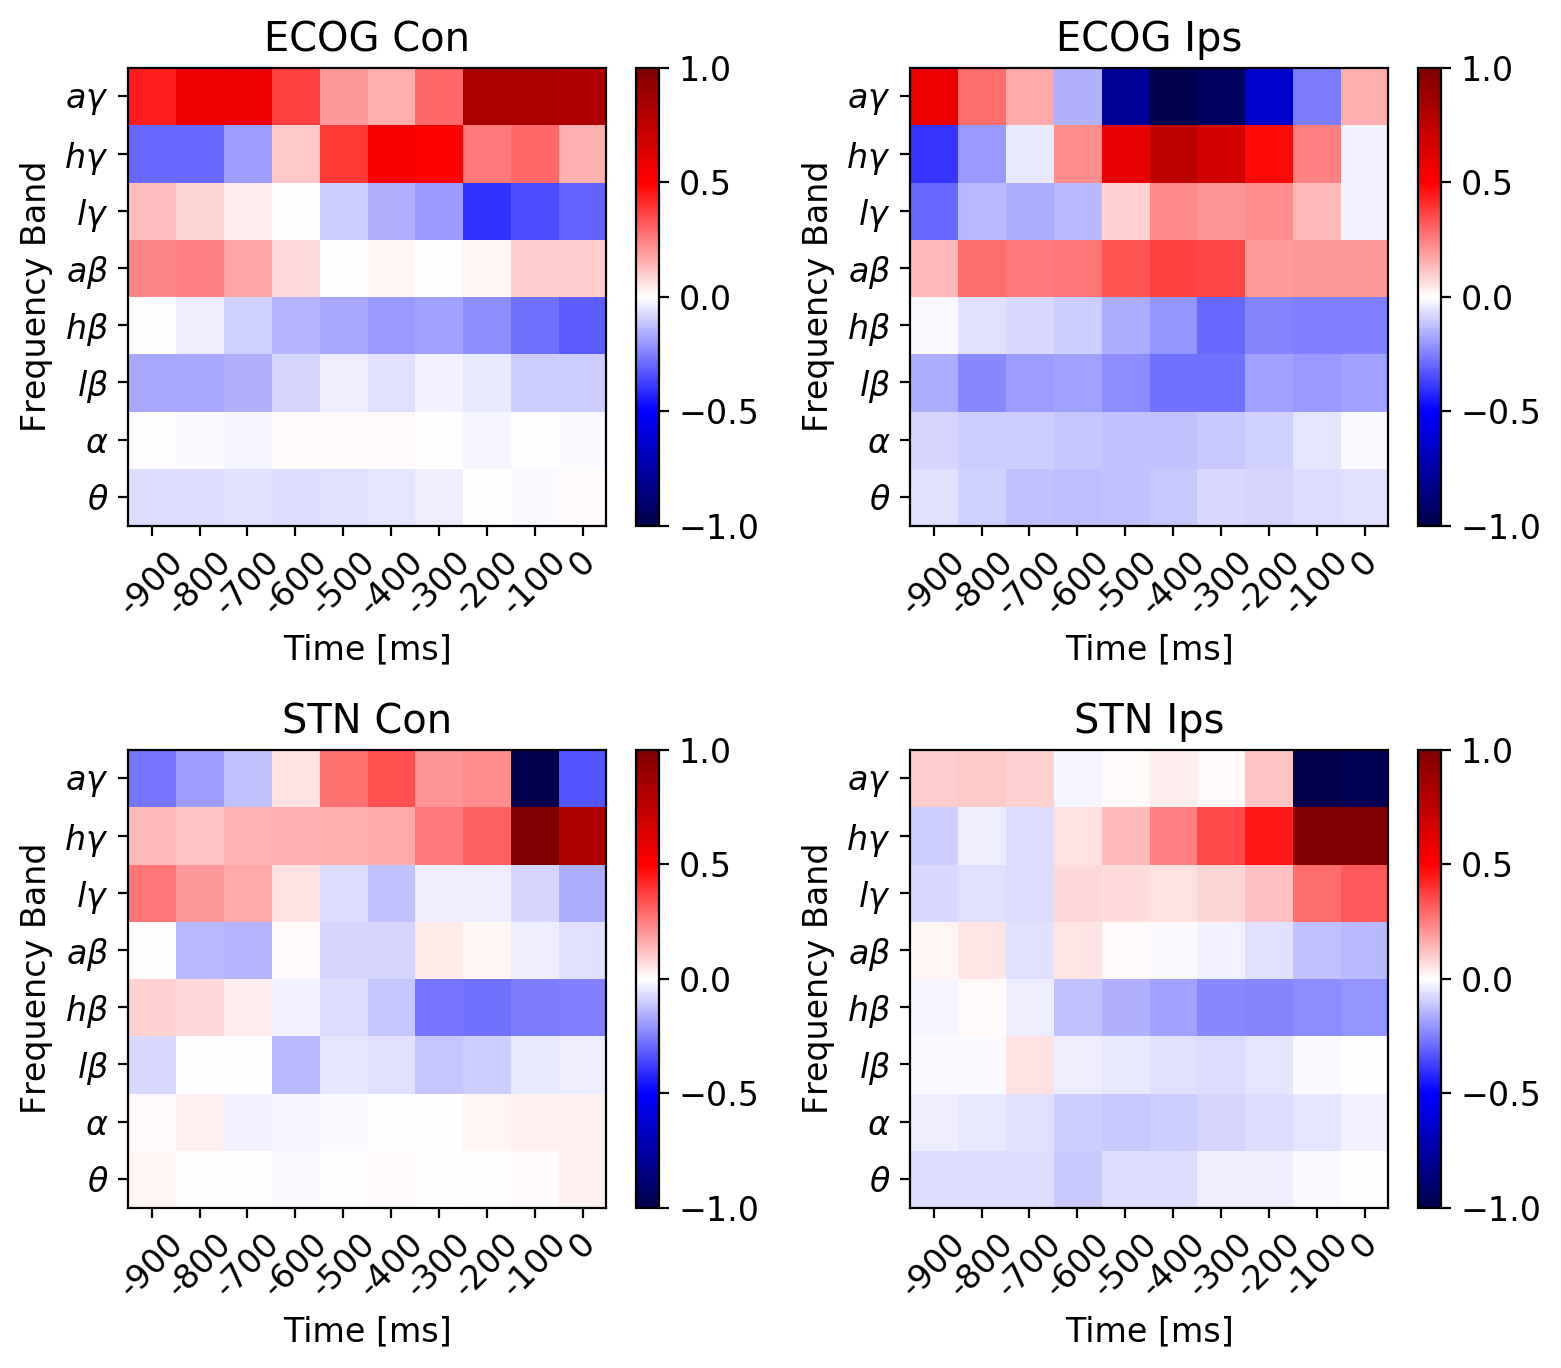

In [69]:
clim_low = -1; clim_high = 1
plt.figure(figsize=(8,7), dpi=200)
plt.subplot(2,2,1)
plt.imshow(arr_[0,:,:].T, aspect='auto', cmap='seismic')
plt.colorbar()
plt.clim(clim_low,clim_high)
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700','-800', '-900','-1000ms'], 
          rotation=45, horizontalalignment = 'center')
plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.xlabel('Time [ms]'); plt.ylabel('Frequency Band'); plt.title('ECOG Con')
plt.subplot(2,2,2)
plt.imshow(arr_[1,:,:].T, aspect='auto', cmap='seismic')
plt.colorbar()
plt.clim(clim_low,clim_high)
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700','-800', '-900','-1000ms'], 
          rotation=45, horizontalalignment = 'center')
plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.xlabel('Time [ms]'); plt.ylabel('Frequency Band'); plt.title('ECOG Ips')
plt.subplot(2,2,3)
plt.imshow(arr_[2,:,:].T, aspect='auto', cmap='seismic')
plt.colorbar()
plt.clim(clim_low,clim_high)
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700','-800', '-900','-1000ms'], 
          rotation=45, horizontalalignment = 'center')
plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.xlabel('Time [ms]'); plt.ylabel('Frequency Band'); plt.title('STN Con')
plt.subplot(2,2,4)
plt.imshow(arr_[3,:,:].T, aspect='auto', cmap='seismic')
plt.colorbar()
plt.clim(clim_low,clim_high)
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.xticks(np.arange(10), ['0', '-100', '-200', '-300', '-400', '-500', '-600', '-700','-800', '-900','-1000ms'], 
          rotation=45, horizontalalignment = 'center')
plt.yticks(np.arange(8), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
plt.xlabel('Time [ms]'); plt.ylabel('Frequency Band'); plt.title('STN Ips')
plt.tight_layout()

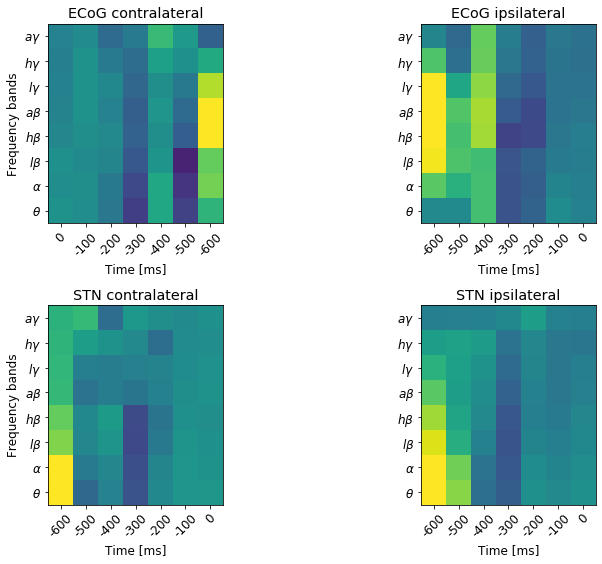

In [42]:
plt.figure(figsize=(12,8))#, dpi=300)
plt.subplot(2,2,1)
plot_weights(arr_[0,:,:], 'ECoG contralateral'); plt.ylabel('Frequency bands'); plt.gca().invert_xaxis()
plt.subplot(2,2,2)
plot_weights(arr_[1,:,:], 'ECoG ipsilateral'); plt.subplot(2,2,3)
plt.ylabel('Frequency bands')
plot_weights(arr_[2,:,:], 'STN contralateral'); plt.subplot(2,2,4)
plot_weights(arr_[3,:,:], 'STN ipsilateral', True)
plt.tight_layout()

In [ ]:
# Ziel hier: estimate individual performances given that every band at every time point should be evaluated
# this resembles a LM per time time and frequency point 

In [31]:

arr_ = np.zeros([4,10,8])
for time_shift in range(10):
    out_here = '/home/icn/Documents/raw_out/time_shift/LM_' + str(time_shift)+'/'
    weights_ecog_con, weights_ecog_ips, weights_stn_con, weights_stn_ips = \
        get_best_weights_single_time_point(out_here)
    arr_[0,time_shift,:] = np.mean(weights_ecog_con, axis=0)
    arr_[1,time_shift,:] = np.mean(weights_ecog_ips, axis=0)
    arr_[2,time_shift,:] = np.mean(weights_stn_con, axis=0)
    arr_[3,time_shift,:] = np.mean(weights_stn_ips, axis=0)

(12, 8)

In [17]:
out_path = '/home/icn/Documents/raw_out/RF_32_4/'

In [39]:
ECOG_con = []; ECOG_ips = []; STN_con = []; STN_ips = []
for t in np.arange(100, 800, 100):
    out_here = '/home/icn/Documents/raw_out/'+'LM_'+str(t)+'ms/'
    ECOG_con_time = []; ECOG_ips_time = []; STN_con_time = []; STN_ips_time = []
    for subject_id_ in subject_id:
        if subject_id_ in subject_exclude:
            continue
        with open(out_here+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
            try:
                ECOG_con_time.append(get_best(dict_ch, Con=True, ECOG=True)[1])
                ECOG_ips_time.append(get_best(dict_ch, Con=False, ECOG=True)[1])
                STN_con_time.append(get_best(dict_ch, Con=True, ECOG=False)[1])
                STN_ips_time.append(get_best(dict_ch, Con=False, ECOG=False)[1])
            except ValueError: # no STN 
                pass
    ECOG_con.append(ECOG_con_time); ECOG_ips.append(ECOG_ips_time); 
    STN_con.append(STN_con_time); STN_ips.append(STN_ips_time); 

In [18]:
def my_boxplot(alpha_con, alpha_ips):
    data_a = alpha_con
    data_b = alpha_ips
    ticks = [str(i) for i in range(len(alpha_con))]

    bpl = plt.boxplot(data_a, positions=np.array(range(len(ticks)))*2.0-0.4, widths=0.6, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(ticks)))*2.0+0.4, widths=0.6, patch_artist=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='contralateral')
    plt.plot([], c='blue', label='ipsilateral')
    plt.xticks(range(0, len(ticks) * 2, 2), ['alpha', 'theta', 'low beta', 'high beta', 'all beta', \
                        'low gamma', 'high gamma', 'all gamma'], rotation=45)
    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('patient')
    plt.tight_layout()
    

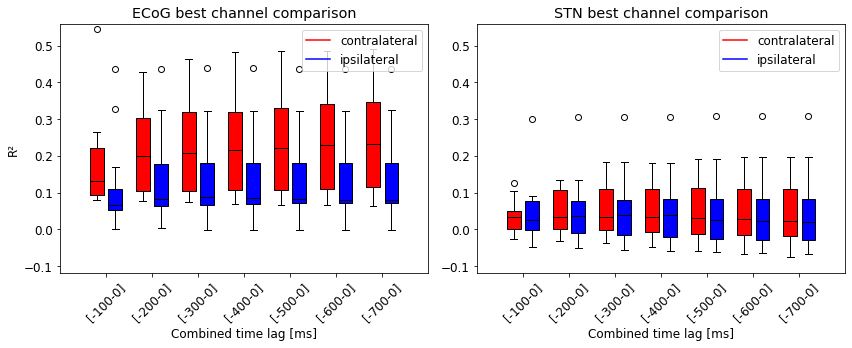

In [41]:
plt.figure(figsize=(12,5))#, dpi=300)
plt.subplot(121)
my_boxplot(ECOG_con, ECOG_ips)
plt.xticks(range(0, len(ECOG_con) * 2, 2), \
           ['[-100-0]', '[-200-0]', '[-300-0]', '[-400-0]', '[-500-0]', '[-600-0]', '[-700-0]'], rotation=45)

#plt.gca().invert_xaxis()
plt.xlabel('Combined time lag [ms]')
plt.ylim(-0.12, 0.56)
plt.ylabel('R²')
plt.legend(loc='upper right')
plt.title('ECoG best channel comparison')
#plt.grid(True)
plt.subplot(122)
my_boxplot(STN_con, STN_ips)
plt.xticks(range(0, len(ECOG_con) * 2, 2), \
           ['[-100-0]', '[-200-0]', '[-300-0]', '[-400-0]', '[-500-0]', '[-600-0]', '[-700-0]'], rotation=45)

#plt.gca().invert_xaxis()
plt.xlabel('Combined time lag [ms]')
plt.ylim(-0.12, 0.56)
#plt.ylabel('R²')
plt.legend(loc='upper right')
plt.title('STN best channel comparison')
plt.tight_layout()
#plt.grid(True)

### Plot Distance Correlation with Hand Knob and STN area

In [14]:
out_path='/home/icn/Documents/raw_out/RF_32_4/'
l_choords_ecog_con = []; c_ecog_con = []
l_choords_ecog_ips = []; c_ecog_ips = []
l_choords_stn_con = []; c_stn_con = []
l_choords_stn_ips = []; c_stn_ips = []
#question here: get l_choords_con and ips
for subject_id_ in subject_id:
    with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        if subject_id_ in subject_exclude: 
            continue
        dict_ch = json.load(fp)

        channels = list(dict_ch.keys())
        ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
        ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]

        x,y,z,c = get_x_y_c(dict_ch, ind_ECOG, Con=True, return_z=True)
        l_choords_ecog_con.append([x,y,z]); c_ecog_con.append(c)
        x,y,z,c = get_x_y_c(dict_ch, ind_ECOG, Con=False, return_z=True)
        l_choords_ecog_ips.append([x,y,z]); c_ecog_ips.append(c)
        if subject_id_ not in ['012', '011', '002', '003']:
            x,y,z,c = get_x_y_c(dict_ch, ind_STN, Con=True, return_z=True)
            l_choords_stn_con.append([x,y,z]); c_stn_con.append(c)
            x,y,z,c = get_x_y_c(dict_ch, ind_STN, Con=False, return_z=True)
            l_choords_stn_ips.append([x,y,z]); c_stn_ips.append(c)
          

In [15]:
def get_choords_n_per(l_choords, c_):
    """ return the concatenated coordinates and performances across all channels
    """
    start = 0
    for patient_idx in range(len(l_choords)):
        if start == 0:
            start = 1
            all_ = np.array(l_choords[patient_idx])
        else:
            all_ = np.concatenate((all_, np.array(l_choords[patient_idx])), axis=1)
    
    return all_, np.concatenate(c_).flatten()

In [16]:
def get_dist_arr(choords_ecog, choords_stn):
    knob_ecog = np.array([37, -25, 64])
    knob_stn = np.array([12.58, -13.41, -5.87])
    
    choords_ecog[0,:] = np.abs(choords_ecog[0,:])
    dist_ecog = np.zeros(choords_ecog.shape[1])
    for choord in range(choords_ecog.shape[1]):
        dist_ecog[choord] = np.linalg.norm(choords_ecog[:,choord] - knob_ecog)
    
    choords_stn[0,:] = np.abs(choords_stn[0,:])
    dist_stn = np.zeros(choords_stn.shape[1])
    for choord in range(choords_stn.shape[1]):
        dist_stn[choord] = np.linalg.norm(choords_stn[:,choord] - knob_stn)
    return dist_ecog, dist_stn    

def get_dist_ecog(choords_ecog):
    knob_ecog = np.array([37, -25, 64])
    
    choords_ecog[0,:] = np.abs(choords_ecog[0,:])
    dist_ecog = np.zeros(choords_ecog.shape[1])
    for choord in range(choords_ecog.shape[1]):
        dist_ecog[choord] = np.linalg.norm(choords_ecog[:,choord] - knob_ecog)
    
    return dist_ecog    

def get_dist_stn(choords_stn):
    knob_stn = np.array([12.58, -13.41, -5.87])

    choords_stn[0,:] = np.abs(choords_stn[0,:])
    dist_stn = np.zeros(choords_stn.shape[1])
    for choord in range(choords_stn.shape[1]):
        dist_stn[choord] = np.linalg.norm(choords_stn[:,choord] - knob_stn)
    return dist_stn    

In [17]:
def my_box_plot_comparison_here(data_a, data_b, label_1='contralateral', label_2='ipsilateral'):

    ticks = [str(i) for i in range(2)]
    bpl = plt.boxplot(data_a, positions=np.array(range(2))*2.0-0.4, sym='', widths=0.45, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(2))*2.0+0.4, sym='', widths=0.45, patch_artist=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label=label_1)
    plt.plot([], c='blue', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('frequency bands')
    plt.tight_layout()
    plt.xticks(range(0, len(ticks) * 2, 2), ['ECOG', 'STN'], rotation=45)

In [18]:
all_ecog, c_ecog_con_ = get_choords_n_per(l_choords_ecog_con, c_ecog_con)
all_stn, c_stn_con_ = get_choords_n_per(l_choords_stn_con, c_stn_con)
dist_ecog, dist_stn  = dist_ecog_con = get_dist_arr(all_ecog, all_stn)

all_ecog, c_ecog_ips_ = get_choords_n_per(l_choords_ecog_ips, c_ecog_ips)
all_stn, c_stn_ips_ = get_choords_n_per(l_choords_stn_ips, c_stn_ips)
dist_ecog, dist_stn  = dist_ecog_con = get_dist_arr(all_ecog, all_stn)

c_ecog_ips_ = np.arctanh(c_ecog_ips_)
c_stn_ips_ = np.nan_to_num(np.arctanh(c_stn_ips_))
c_ecog_con_ = np.arctanh(c_ecog_con_)
c_stn_con_ = np.nan_to_num(np.arctanh(c_stn_con_))

/home/icn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arctanh
  # Remove the CWD from sys.path while we load stuff.
/home/icn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arctanh
  if sys.path[0] == '':


In [19]:
r_dist_r2_ecog_con = []; r_dist_r2_ecog_ips = []; 
r_dist_r2_stn_con = []; r_dist_r2_stn_ips = []; 

for patient_idx in range(len(c_ecog_con)):
    
    r_dist_r2_ecog_con.append(stats.spearmanr(get_dist_ecog(np.array(l_choords_ecog_con[patient_idx])), \
                                    np.arctanh(c_ecog_con[patient_idx]))[0])
    r_dist_r2_ecog_ips.append(stats.spearmanr(get_dist_ecog(np.array(l_choords_ecog_ips[patient_idx])), \
                                    np.arctanh(c_ecog_ips[patient_idx]))[0])
    if patient_idx >= len(l_choords_stn_con):
        continue
    r_dist_r2_stn_con.append(stats.spearmanr(get_dist_ecog(np.array(l_choords_stn_con[patient_idx])), \
                                    np.arctanh(c_stn_con[patient_idx]))[0])
    if patient_idx >= len(l_choords_stn_ips):
        continue
    r_dist_r2_stn_ips.append(stats.spearmanr(get_dist_ecog(np.array(l_choords_stn_ips[patient_idx])), \
                                    np.arctanh(c_stn_ips[patient_idx]))[0])
    

/home/icn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arctanh
  del sys.path[0]
/home/icn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arctanh


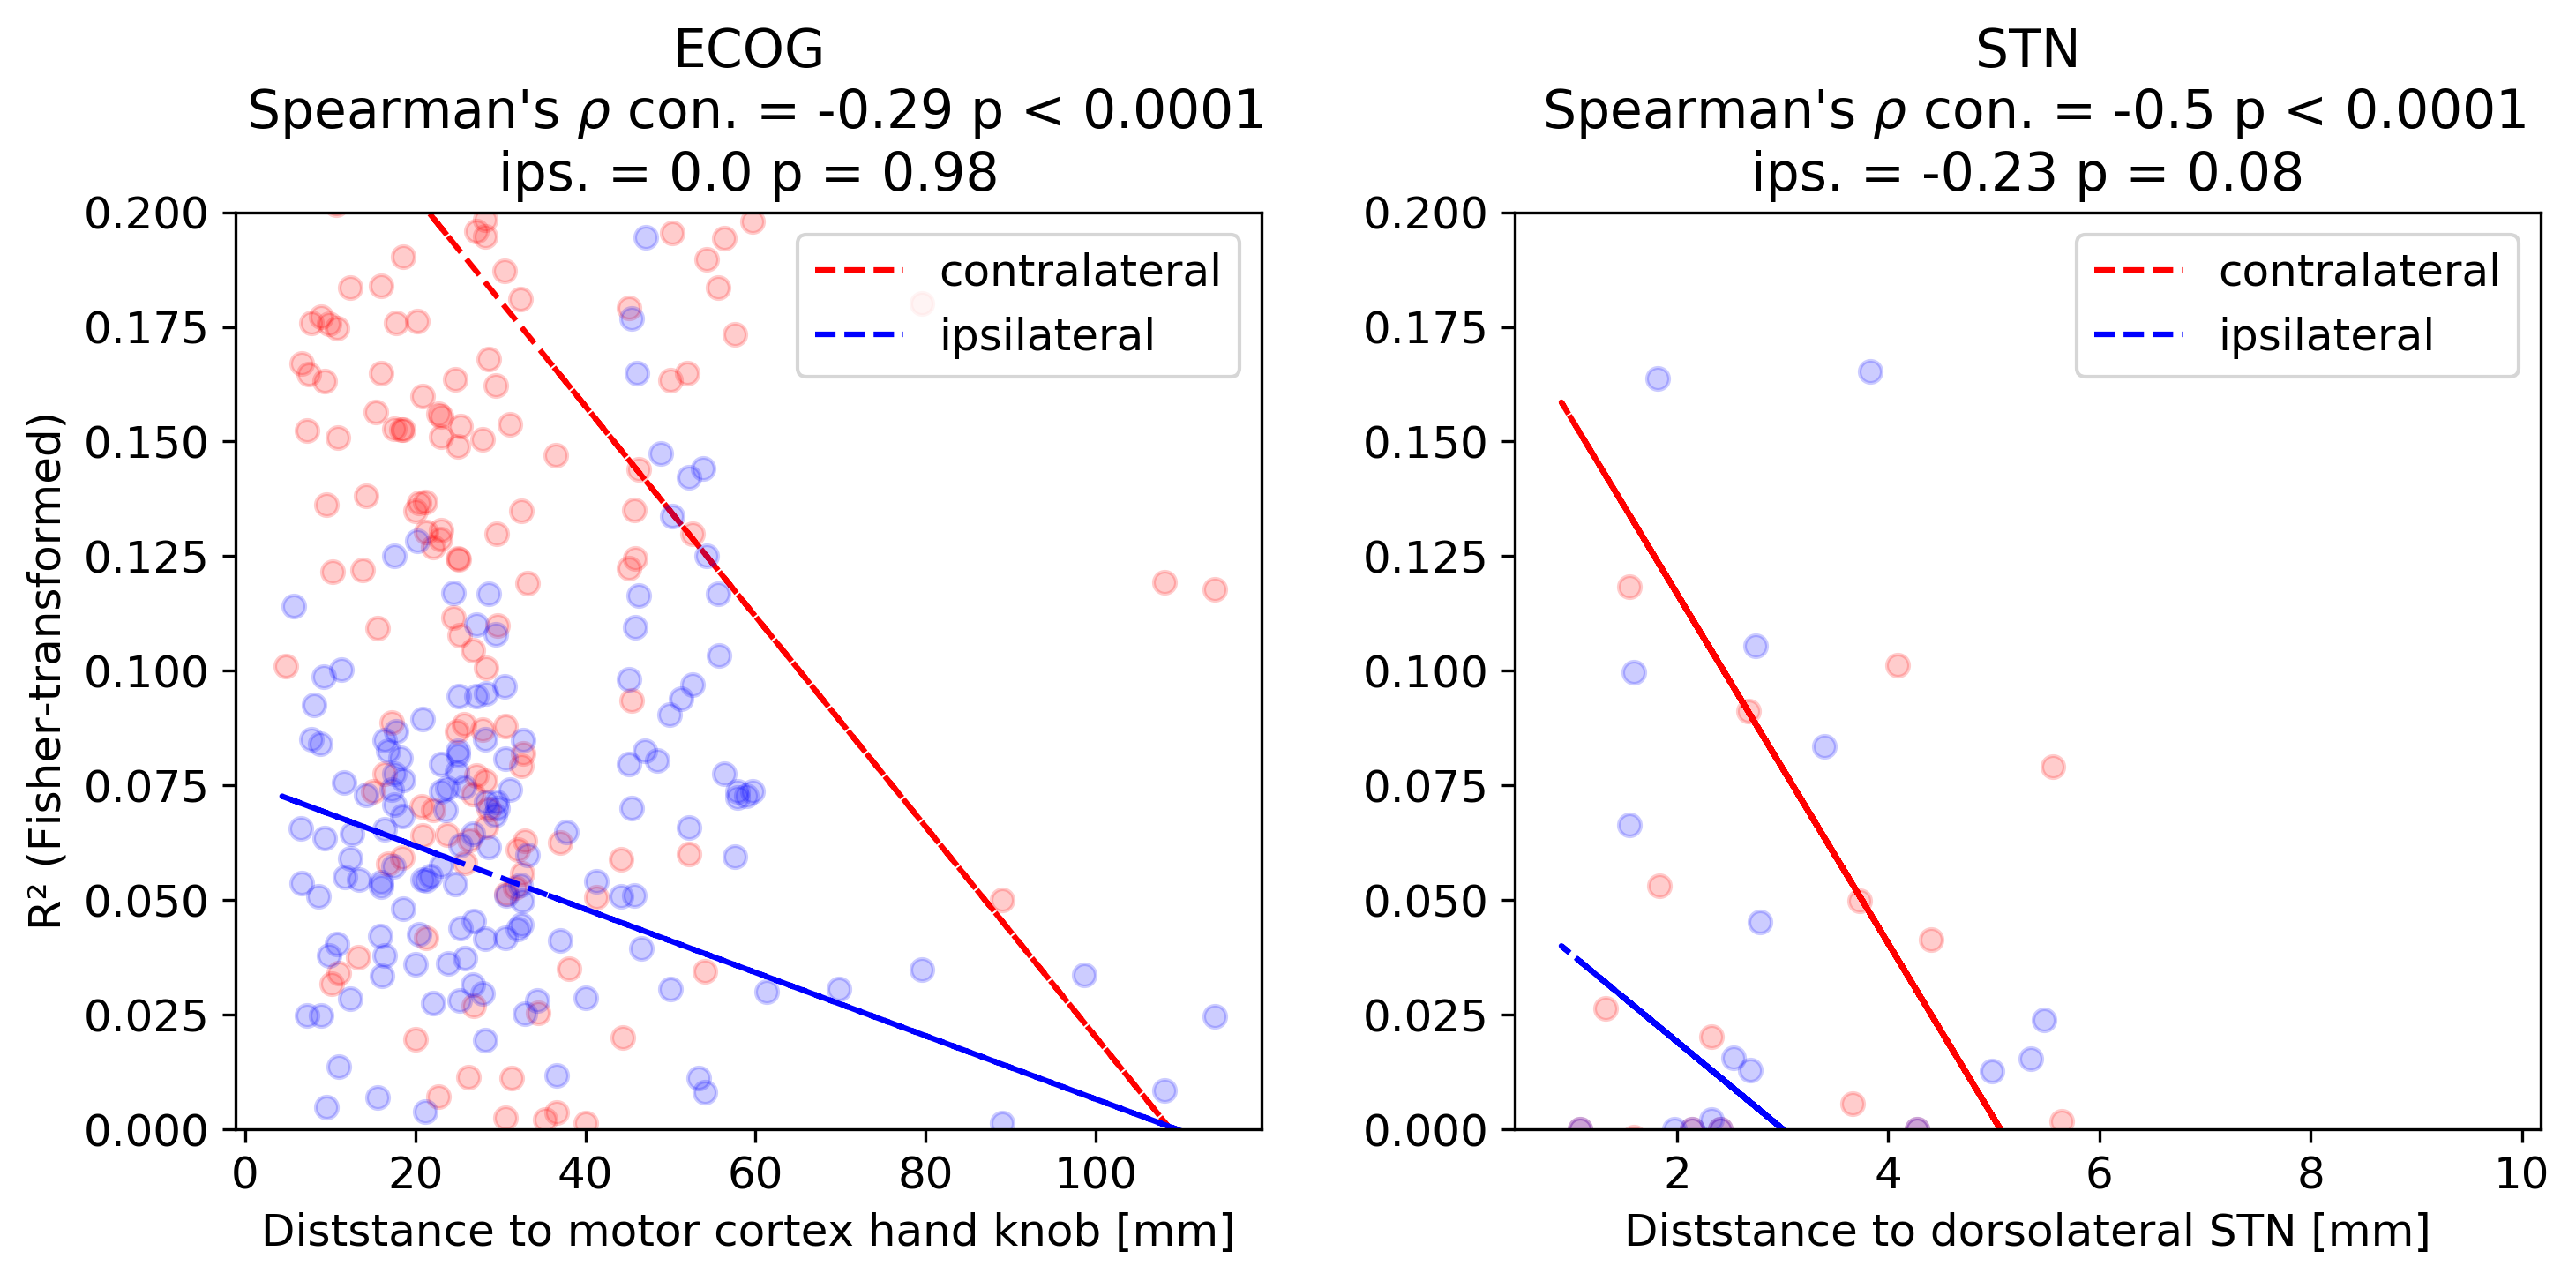

In [20]:
plt.figure(figsize=(10,5), dpi=300)
plt.subplot(121)
color='r'


plt.plot(dist_ecog, c_ecog_con_, str(color)+'o', alpha=0.2)
coef = np.polyfit(dist_ecog, c_ecog_con_, 1)
poly1d_fn = np.poly1d(coef) 
plt.plot(dist_ecog, poly1d_fn(dist_ecog), '--r', label='contralateral')

all_ecog, c_ecog_ips_ = get_choords_n_per(l_choords_ecog_ips, c_ecog_ips)
all_stn, c_stn_ips_ = get_choords_n_per(l_choords_stn_ips, c_stn_ips)
dist_ecog, dist_stn  = dist_ecog_con = get_dist_arr(all_ecog, all_stn)

res_ecog_con = stats.spearmanr(dist_ecog, c_ecog_con_) # 0: stat, 1:p
res_ecog_ips = stats.spearmanr(dist_ecog, c_ecog_ips_)
res_stn_con = stats.spearmanr(dist_stn, c_stn_con_)
res_stn_ips = stats.spearmanr(dist_stn, c_stn_ips_)

color='b'
plt.plot(dist_ecog, c_ecog_ips_, str(color)+'o', alpha=0.2)
coef = np.polyfit(dist_ecog, c_ecog_ips_, 1)
poly1d_fn = np.poly1d(coef) 
plt.plot(dist_ecog, poly1d_fn(dist_ecog), '--b', label='ipsilateral')
plt.legend(loc='upper right')
plt.xlabel('Diststance to motor cortex hand knob [mm]')
plt.ylabel('R² (Fisher-transformed)')
plt.ylim(0,0.2)
plt.title('ECOG'+'\n Spearman\'s '+r'$\rho$'+ ' con. = '+str(np.round(res_ecog_con[0],2)) + \
          ' p < 0.0001'+' \nips. = '+str(np.round(res_ecog_ips[0],2)) + ' p = '+\
         str(np.round(res_ecog_ips[1],2)))


plt.subplot(122)
color='r'
c_stn_con_[c_stn_con_ < -2] = 0
plt.plot(dist_stn, c_stn_con_, str(color)+'o', alpha=0.2)
coef = np.polyfit(dist_stn, c_stn_con_, 1)
poly1d_fn = np.poly1d(coef) 
plt.plot(dist_stn, poly1d_fn(dist_stn), '--r', label='contralateral')

color='b'
c_stn_ips_[c_stn_ips_ < -2] = 0
plt.plot(dist_stn, c_stn_ips_, str(color)+'o', alpha=0.2)
coef = np.polyfit(dist_stn, c_stn_ips_, 1)
poly1d_fn = np.poly1d(coef) 
plt.plot(dist_stn, poly1d_fn(dist_stn), '--b', label='ipsilateral')
plt.legend(loc='upper right')
plt.xlabel('Diststance to dorsolateral STN [mm]')
#plt.ylabel('R²')
plt.ylim(0,0.2)
plt.title('STN'+'\n Spearman\'s '+r'$\rho$'+ ' con. = '+str(np.round(res_stn_con[0],2)) + \
          ' p < 0.0001'+' \nips. = '+str(np.round(res_stn_ips[0],2)) + ' p = '+\
         str(np.round(res_stn_ips[1],2)))

plt.tight_layout()


### question: How many times is the best channel actually the one that is closest? 

In [23]:
patient_idx = 0
get_dist_ecog(np.array(l_choords_ecog_con[patient_idx]))

array([23.71475573, 12.71865663,  4.52494857,  8.46667872, 19.79278943,
       29.51288421])

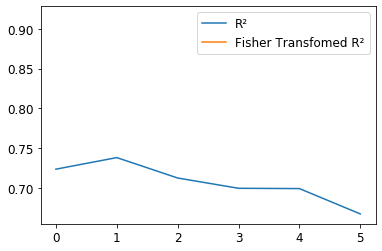

In [28]:
plt.plot(c_ecog_con[patient_idx], label='R²')
plt.plot(c_ecog_con_[patient_idx], label='Fisher Transfomed R²')
plt.legend()

In [34]:
c_ecog_con[patient_idx]

array([0.72383689, 0.73834149, 0.71274733, 0.69985129, 0.69947607,
       0.66770605])

In [35]:
get_dist_ecog(np.array(l_choords_ecog_con[patient_idx]))

array([23.71475573, 12.71865663,  4.52494857,  8.46667872, 19.79278943,
       29.51288421])

In [39]:
np.array(l_choords_ecog_con[patient_idx])

(3, 6)

In [42]:
choord_closest.shape

(11, 3)

In [43]:
choord_best.shape

(11, 3)

### plot that on a brain 


In [47]:
x_ecog.shape

(307146,)

In [48]:
y_ecog.shape

(307146,)

In [83]:
len(l_choords_ecog_con[0]

3

In [21]:
def get_coord_all(l_choords_ecog_con):
    x_ = []; y_ = []
    for patient_idx in range(len(l_choords_ecog_con)):
        x_.append(np.array(l_choords_ecog_con[patient_idx])[0,:])
        y_.append(np.array(l_choords_ecog_con[patient_idx])[1,:])
    return np.concatenate(np.array(x_)), np.concatenate(np.array(y_))

In [116]:
x_, y_ = get_coord_all(l_choords_ecog_con)

In [118]:
x_.shape

(208,)

In [22]:
choord_closest = []
choords_best = []
for patient_idx in range(len(c_ecog_con)):
    best_idx_performance = np.argmax(c_ecog_con[patient_idx])
    closes_point_idx = np.argmin(get_dist_ecog(np.array(l_choords_ecog_con[patient_idx])))
    choord_closest.append(np.array(l_choords_ecog_con[patient_idx])[:,closes_point_idx])
    choords_best.append(np.array(l_choords_ecog_con[patient_idx])[:,best_idx_performance])
choord_closest_ECOG = np.array(choord_closest)
choord_best_ECOG = np.array(choords_best)

In [23]:
choord_closest = []
choords_best = []
for patient_idx in range(len(c_stn_con)):
    best_idx_performance = np.argmax(c_stn_con[patient_idx])
    closes_point_idx = np.argmin(get_dist_stn(np.array(l_choords_stn_con[patient_idx])))
    choord_closest.append(np.array(l_choords_stn_con[patient_idx])[:,closes_point_idx])
    choords_best.append(np.array(l_choords_stn_con[patient_idx])[:,best_idx_performance])
choord_closest_STN = np.array(choord_closest)
choord_best_STN = np.array(choords_best)

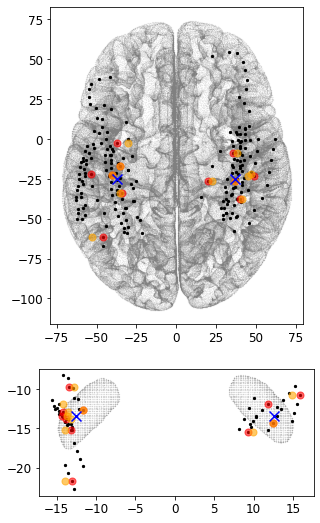

In [24]:
height_STN = 1
height_ECOG = 2.5*height_STN
fig, axes = plt.subplots(2,1, facecolor=(1,1,1), gridspec_kw={'height_ratios': [height_ECOG, height_STN]}, \
                         figsize=(14,9))#, dpi=300)
axes[0].scatter(x_ecog, y_ecog, c="gray", s=0.001)
x_, y_ = get_coord_all(l_choords_ecog_con)
axes[0].scatter(x_, y_, s=5, c='black')
axes[0].scatter(choord_best_ECOG[:,0], choord_best_ECOG[:,1], c='red', s=50, alpha=0.6)
axes[0].scatter(choord_closest_ECOG[:,0], choord_best_ECOG[:,1], c='orange', s=50, alpha=0.6)
axes[0].scatter(37, -25, c='blue', s=100, marker='x')
axes[0].scatter(-37, -25, c='blue', s=100, marker='x')
axes[0].axes.set_aspect('equal', anchor='C')
axes[1].axes.set_aspect('equal', anchor='C')

axes[1].scatter(x_stn, y_stn, c="gray", s=0.001)
x_, y_ = get_coord_all(l_choords_stn_con)
axes[1].scatter(x_, y_, s=5, c='black')
axes[1].scatter(choord_best_STN[:,0], choord_best_STN[:,1], c='red', s=50, alpha=0.6)
axes[1].scatter(choord_closest_STN[:,0], choord_best_STN[:,1], c='orange', s=50, alpha=0.6)
axes[1].scatter(12.58, -13.41, c='blue', s=100, marker='x')
axes[1].scatter(-12.58, -13.41, c='blue', s=100, marker='x')



In [25]:
choord_closest_ECOG

array([[ 40.94303578, -27.21778456,  64.09518408],
       [ 36.63665377, -26.37608385,  69.54412071],
       [ 45.04321704, -31.96746895,  64.97685563],
       [-52.72045409, -29.14040668,  61.99288522],
       [ 38.18972015, -24.8178267 ,  70.54226708],
       [-35.43360925, -24.44872715,  68.46909581],
       [-40.07019771, -22.25517174,  65.32626598],
       [-35.01778655, -16.69116038,  70.63135086],
       [ 47.05582853, -20.44116372,  63.71003876],
       [-30.40031442, -19.46383251,  68.06707619],
       [ 22.39200905, -16.87765229,  65.71559277]])

In [26]:
choord_best_ECOG

array([[ 40.1598943 , -37.31592983,  64.31171618],
       [ 36.63665377, -26.37608385,  69.54412071],
       [ 48.70757197, -23.26678237,  63.30849755],
       [-45.92222808, -61.41611027,  59.50678603],
       [ 35.44324324,  -9.05109761,  67.67374808],
       [-34.19106518, -33.78922865,  69.6956376 ],
       [-40.07019771, -22.25517174,  65.32626598],
       [-35.01778655, -16.69116038,  70.63135086],
       [-53.40543113, -22.0825916 ,  58.48703105],
       [-36.97793658,  -2.73717556,  59.49827914],
       [ 19.98270199, -26.37155434,  68.9606791 ]])

In [ ]:
--> 3 GLEICH 

In [ ]:

    height_STN = 1
    height_ECOG = 2.5*height_STN
    fig, axes = plt.subplots(1,1, facecolor=(0,0,0), gridspec_kw={'height_ratios': [height_ECOG, height_STN]}, \
                             figsize=(14,9))#, dpi=300)
    axes[0, idx].scatter(x_ecog, y_ecog, c="gray", s=0.001)
    axes[1, idx].scatter(x_stn, y_stn, c="gray", s=0.001)
    axes[1, idx].scatter(x, y, c=c, s=10, alpha=0.8)
    
    for idx in range(2):
        axes[0, idx].scatter(x_ecog, y_ecog, c="gray", s=0.001)
        axes[1, idx].scatter(x_stn, y_stn, c="gray", s=0.001)
        for sub_idx, subject_id_ in enumerate(subject_id[:-1]):  
            if subject_id_ in subject_exclude: 
                continue
            with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
                dict_ch = json.load(fp)
            channels = list(dict_ch.keys())
            ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
            ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]
            if idx == 0:
                x,y,c = get_x_y_c(dict_ch, ind_ECOG, Con=True)
            else:
                x,y,c = get_x_y_c(dict_ch, ind_ECOG, Con=False)
            pos_ecog = axes[0, idx].scatter(x, y, c=c, s=10, alpha=0.8)
            if idx == 0:
                x,y,c = get_x_y_c(dict_ch, ind_STN, Con=True)
            else:
                x,y,c = get_x_y_c(dict_ch, ind_STN, Con=False)
            if subject_id_ not in ['012', '003']:
                pos_stn = axes[1, idx].scatter(x, y, c=c, s=10, alpha=0.8)
                cbar_stn = fig.colorbar(pos_stn, ax=axes[1, idx]); pos_stn.set_clim(0,0.5); cbar_stn.remove()

            cbar_ecog = fig.colorbar(pos_ecog, ax=axes[0, idx]); pos_ecog.set_clim(0,0.5); cbar_ecog.remove()

        if idx == 1:
            cbar_ecog = fig.colorbar(pos_ecog, ax=axes[0, idx]); pos_ecog.set_clim(0,0.5); 
            cbar_ecog.set_label('R²', color="white")
            cbar_ecog.ax.tick_params(axis='y', color='white')
            cbar_ecog.ax.set_yticklabels(labels=np.round(cbar_ecog.get_ticks(),2),color='white')
            cbar_ecog.outline.set_edgecolor('white')
        if idx == 0:
            axes[0, idx].set_title('contralateral performance', color='white')
        else:
            axes[0, idx].set_title('ipsilateral performance', color='white')
        axes[0, idx].axes.set_aspect('equal', anchor='C')
        axes[0, idx].set_facecolor((0,0,0))
        axes[1, idx].axes.set_aspect('equal', anchor='C')
        axes[1, idx].set_facecolor((0,0,0))


In [34]:
res_ecog_con

SpearmanrResult(correlation=-0.29191536914649036, pvalue=1.8837087924286198e-05)

In [35]:
res_ecog_ips

SpearmanrResult(correlation=0.0017709216793884988, pvalue=0.9797465195462397)

In [36]:
res_stn_con

SpearmanrResult(correlation=-0.49717938509667065, pvalue=5.3201940236333636e-05)

In [37]:
res_stn_ips

SpearmanrResult(correlation=-0.23100861350375107, pvalue=0.07575777997721007)

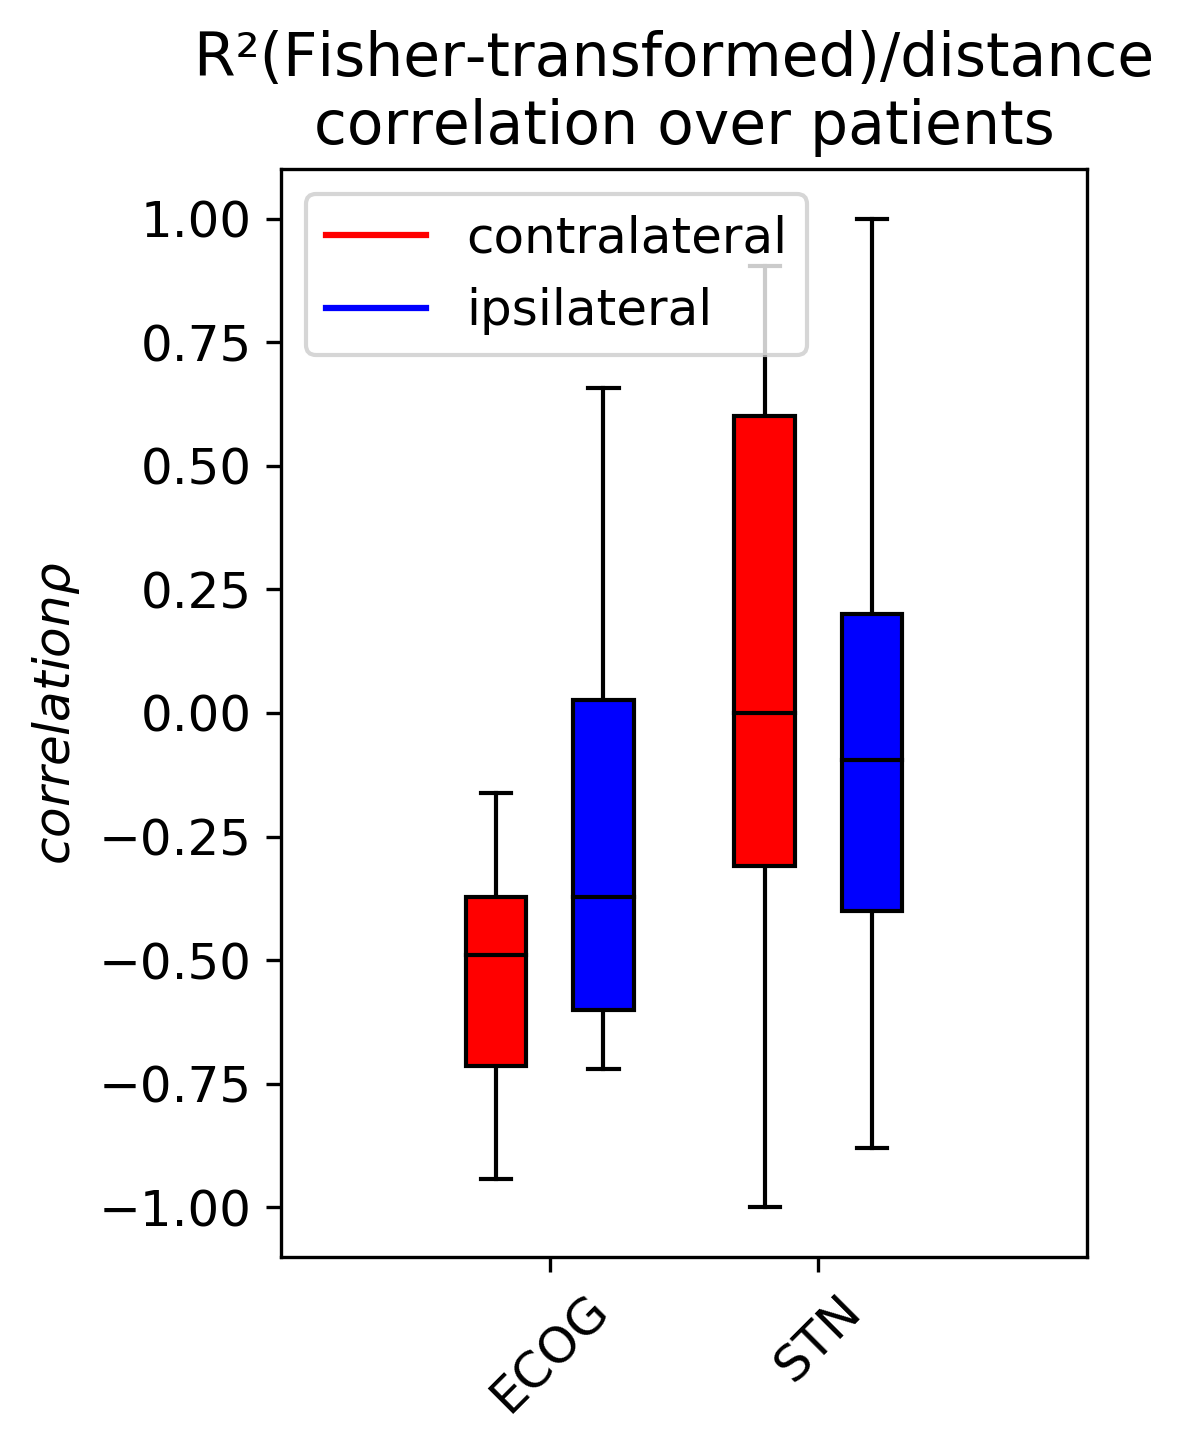

In [50]:
plt.figure(figsize=(4,5), dpi=300)
my_box_plot_comparison_here([np.nan_to_num(r_dist_r2_ecog_con), np.nan_to_num(r_dist_r2_stn_con)], \
                           [np.nan_to_num(r_dist_r2_ecog_ips), np.nan_to_num(r_dist_r2_stn_ips)])
plt.legend(loc='upper left')
plt.ylabel(r'$ correlation \rho$')
#plt.grid(True)
#plt.title('spearman\'s correlation coefficient distance channel/hand knob vs AUC performance across channels')
plt.title('R²(Fisher-transformed)/distance \ncorrelation over patients')
plt.ylim(-1.1, 1.1)
plt.xlabel('')#; plt.ylabel('')
plt.tight_layout()

### best channels for all 

In [20]:

#ECOG con (LM single time point) ist patient000 mit ECOG_RIGHT_0
#ECOG ips (LM single time point) ist patient015 mit ECOG_LEFT_1
#STN con patient 000, STN_RIGHT_1
#STN ips patient 004, STN_RIGHT_2

In [15]:
def analyze_mean_res(out_path, get_weights = True):
    best_ecog_con_ch = []; best_ecog_con = []
    best_ecog_ips_ch = []; best_ecog_ips = []
    best_stn_con_ch = []; best_stn_con = []
    best_stn_ips_ch = []; best_stn_ips = []; l_STN = []
    for subject_id_ in subject_id:
        #if subject_id_ == '006':
        #    continue
        if subject_id_ in subject_exclude: 
            continue
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
            if get_weights is True:
                best_ch, best_acc, best_weights = get_best(dict_ch, Con=True, ECOG=True)
            else:
                best_ch, best_acc = get_best(dict_ch, Con=True, ECOG=True, get_weights=False)
            best_ecog_con_ch.append(best_ch); best_ecog_con.append(best_acc)
            if get_weights is True:
                best_ch, best_acc, best_weights = get_best(dict_ch, Con=False, ECOG=True)
            else:
                best_ch, best_acc = get_best(dict_ch, Con=False, ECOG=True, get_weights=False)
            best_ecog_ips_ch.append(best_ch); best_ecog_ips.append(best_acc)
            if subject_id_ not in ['012', '011', '002', '003']:
                if get_weights is True:
                    best_ch, best_acc, best_weights = get_best(dict_ch, Con=True, ECOG=False); l_STN.append(subject_id_)
                else:
                    best_ch, best_acc = get_best(dict_ch, Con=True, ECOG=False,get_weights=False); l_STN.append(subject_id_)

                best_stn_con_ch.append(best_ch); best_stn_con.append(best_acc)
                if get_weights is True:
                    best_ch, best_acc, best_weights = get_best(dict_ch, Con=False, ECOG=False)
                else:
                    best_ch, best_acc = get_best(dict_ch, Con=False, ECOG=False, get_weights=False)
                best_stn_ips_ch.append(best_ch); best_stn_ips.append(best_acc)
    best_ecog_con = np.array(best_ecog_con) 
    best_ecog_con[best_ecog_con<0] = 0
    
    best_ecog_ips = np.array(best_ecog_ips) 
    best_ecog_ips[best_ecog_ips<0] = 0
    
    best_stn_con = np.array(best_stn_con) 
    best_stn_con[best_stn_con<0] = 0
    
    best_stn_ips = np.array(best_stn_ips) 
    best_stn_ips[best_stn_ips<0] = 0

    plt.boxplot([best_ecog_con, best_ecog_ips, best_stn_con, best_stn_ips])
    plt.ylim(0,1)
    plt.xticks(np.arange(1,5), ['ECOG con', 'ECOG ips', 'STN con', 'STN ips'])
    plt.ylabel('R²')
    plt.title('boxplot performances')
    print('ECOG con: '+str(np.round(np.mean(best_ecog_con),2))+' +-'+str(np.round(np.std(best_ecog_con),2)))
    print('ECOG ips: '+str(np.round(np.mean(best_ecog_ips),2))+' +-'+str(np.round(np.std(best_ecog_ips),2)))
    print('STN con: '+str(np.round(np.mean(best_stn_con),2))+' +-'+str(np.round(np.std(best_stn_con),2)))
    print('STN ips: '+str(np.round(np.mean(best_stn_ips),2))+' +-'+str(np.round(np.std(best_stn_ips),2)))
    return best_ecog_con, best_ecog_ips, best_stn_con, best_stn_ips, l_STN

ECOG con: 0.18 +-0.13
ECOG ips: 0.09 +-0.09
STN con: 0.09 +-0.18
STN ips: 0.05 +-0.08


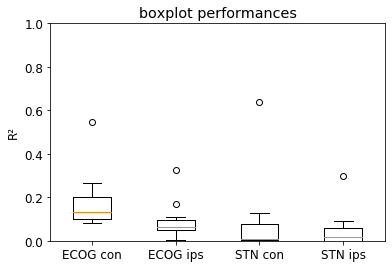

In [69]:
LM_100ms_con,LM_100ms_ips,LM_100ms_stn_con,LM_100ms_stn_ips,_ = analyze_mean_res('/home/icn/Documents/raw_out/LM_100ms/')

ECOG con: 0.26 +-0.19
ECOG ips: 0.1 +-0.08
STN con: 0.09 +-0.19
STN ips: 0.05 +-0.09


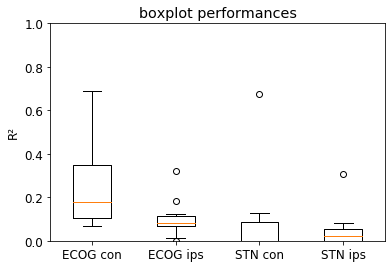

In [70]:
LM_500ms,_,LM_500ms_stn,_,_ = analyze_mean_res('/home/icn/Documents/raw_out/LM_500ms/', get_weights=False)

ECOG con: 0.31 +-0.2
ECOG ips: 0.16 +-0.17
STN con: 0.1 +-0.21
STN ips: 0.06 +-0.09


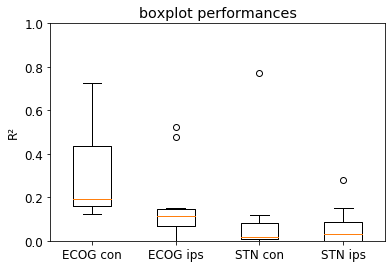

In [71]:
NN_1_4,_,NN_1_4_stn,_,_ = analyze_mean_res('/home/icn/Documents/raw_out/NN_1_4/', get_weights=False)

ECOG con: 0.32 +-0.21
ECOG ips: 0.16 +-0.17
STN con: 0.09 +-0.22
STN ips: 0.06 +-0.08


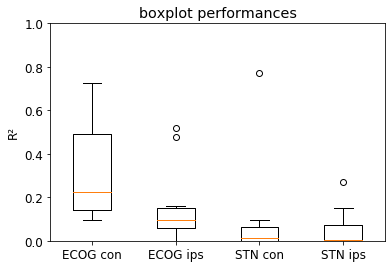

In [72]:
NN_2_5,_,NN_2_5_stn,_,_ = analyze_mean_res('/home/icn/Documents/raw_out/NN_2_5/', get_weights=False)

ECOG con: 0.15 +-0.31
ECOG ips: -0.09 +-0.27
STN con: -1.81 +-5.73
STN ips: -0.79 +-1.96


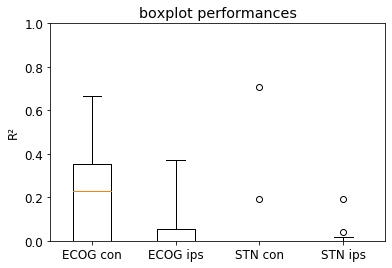

In [67]:
KNN_5_neighbors,_,KNN_5_neighbors_stn,_,_ = analyze_mean_res('/home/icn/Documents/raw_out/KNN_5_neighbors/', get_weights=False)

ECOG con: 0.36 +-0.23
ECOG ips: 0.15 +-0.19
STN con: 0.09 +-0.23
STN ips: 0.04 +-0.09


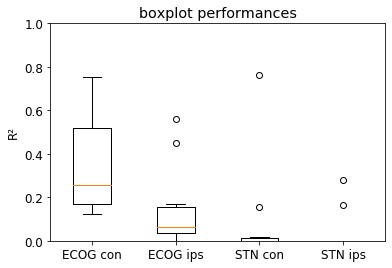

In [75]:
rf_100_10,_,rf_100_10_stn,_,_ = analyze_mean_res('/home/icn/Documents/raw_out/RF_100_10/', get_weights=False)

ECOG con: 0.36 +-0.21
ECOG ips: 0.17 +-0.18
STN con: 0.11 +-0.21
STN ips: 0.06 +-0.11


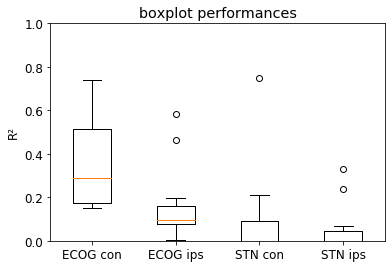

In [73]:
rf_32_4_con,rf_32_4_ips,rf_32_4_stn_con,rf_32_4_stn_ips,_ = analyze_mean_res('/home/icn/Documents/raw_out/RF_32_4/', get_weights=False)

### für die Time plot; use non downsampled 

In [74]:
out_path = '/home/icn/Documents/raw_out/RF_32_4/'
subject_id = '000'
with open(out_path+'sub_'+subject_id+'_patient_concat.json', 'r') as fp:
    dict_ch = json.load(fp)

In [75]:
y_con = np.array(dict_ch['ECOG_RIGHT_1']['true_movements'])[1,:]
y_ips = np.array(dict_ch['ECOG_RIGHT_1']['true_movements'])[0,:]

In [153]:
X = np.array(dict_ch['ECOG_RIGHT_1']['data'])

In [172]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.T, y_con, test_size=0.33, shuffle=False)
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_con = append_time_dim(X_test, y_test, time_stamps=5)
model_ = ensemble.RandomForestRegressor(n_estimators=32, max_depth=4)
model_ = model_.fit(X_train, y_train)
y_pred_con = model_.predict(X_test)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X.T, y_ips, test_size=0.33, shuffle=False)
X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
X_test, y_test_ips = append_time_dim(X_test, y_test, time_stamps=5)
model_ = ensemble.RandomForestRegressor(n_estimators=32, max_depth=4)
model_ = model_.fit(X_train, y_train)
y_pred_ips = model_.predict(X_test)

In [47]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]


Text(0.5, 1.0, 'RF force prediction')

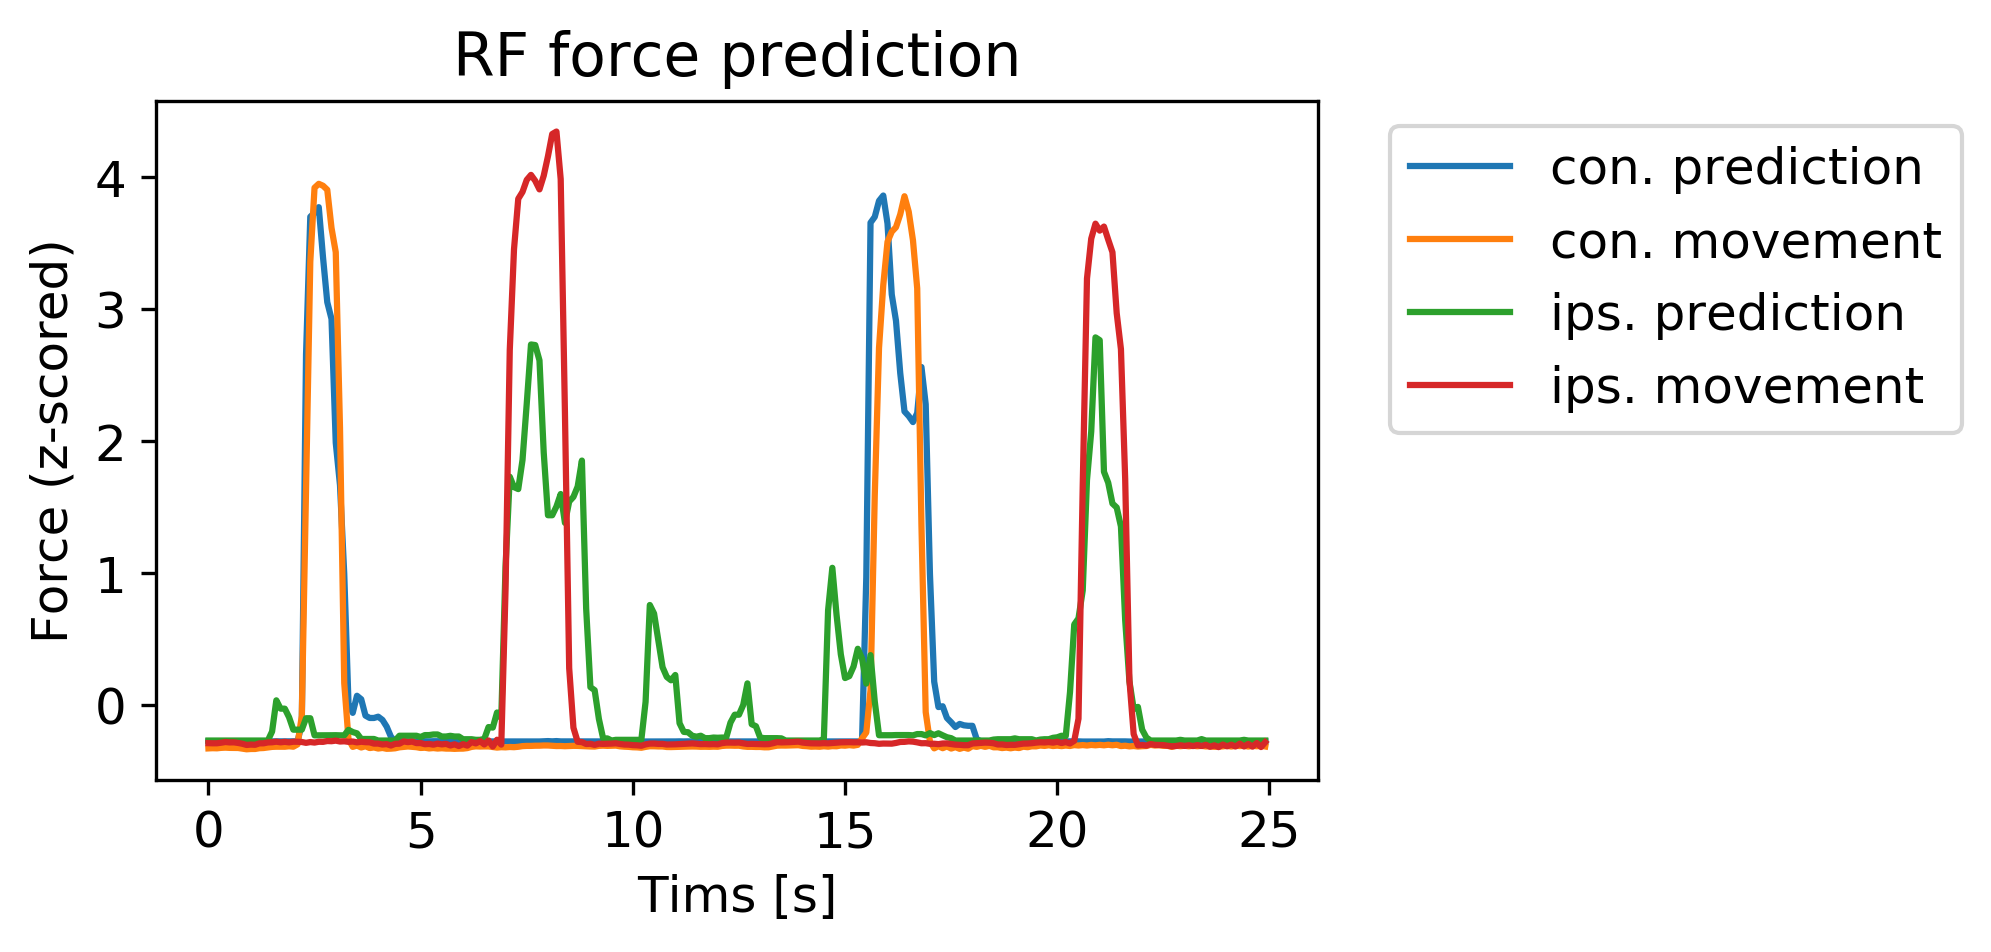

In [182]:
plt.figure(figsize=(5,3), dpi=300)
ind_low = 1250
ind_high = 1500
time_ = np.arange(ind_low-ind_low, ind_high-ind_low, 1)/10
plt.plot(time_, y_pred_con[ind_low:ind_high], label='con. prediction')
plt.plot(time_, y_test_con[ind_low:ind_high], label='con. movement')
plt.plot(time_, y_pred_ips[ind_low:ind_high], label='ips. prediction')
plt.plot(time_, y_test_ips[ind_low:ind_high], label='ips. movement')
plt.legend(bbox_to_anchor=(1.04,1))#, loc='upper right')
plt.ylabel('Force (z-scored)')
plt.xlabel('Tims [s]')
plt.title('RF force prediction')

In [76]:
def my_box_plot_comparison_here(data_a, data_b, label_1='contralateral', label_2='ipsilateral'):
    ran = len(data_a)
    ticks = [str(i) for i in range(ran)]
    bpl = plt.boxplot(data_a, positions=np.array(range(ran))*2.0-0.4, sym='', widths=0.45, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(ran))*2.0+0.4, sym='', widths=0.45, patch_artist=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label=label_1)
    plt.plot([], c='blue', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('frequency bands')
    plt.tight_layout()
    plt.xticks(range(0, len(ticks) * 2, 2), ['LM_100ms', 'LM_500ms', 'NN_2_5', 'NN_1_4', 'rf_100_10', 'rf_32_4'], rotation=90)

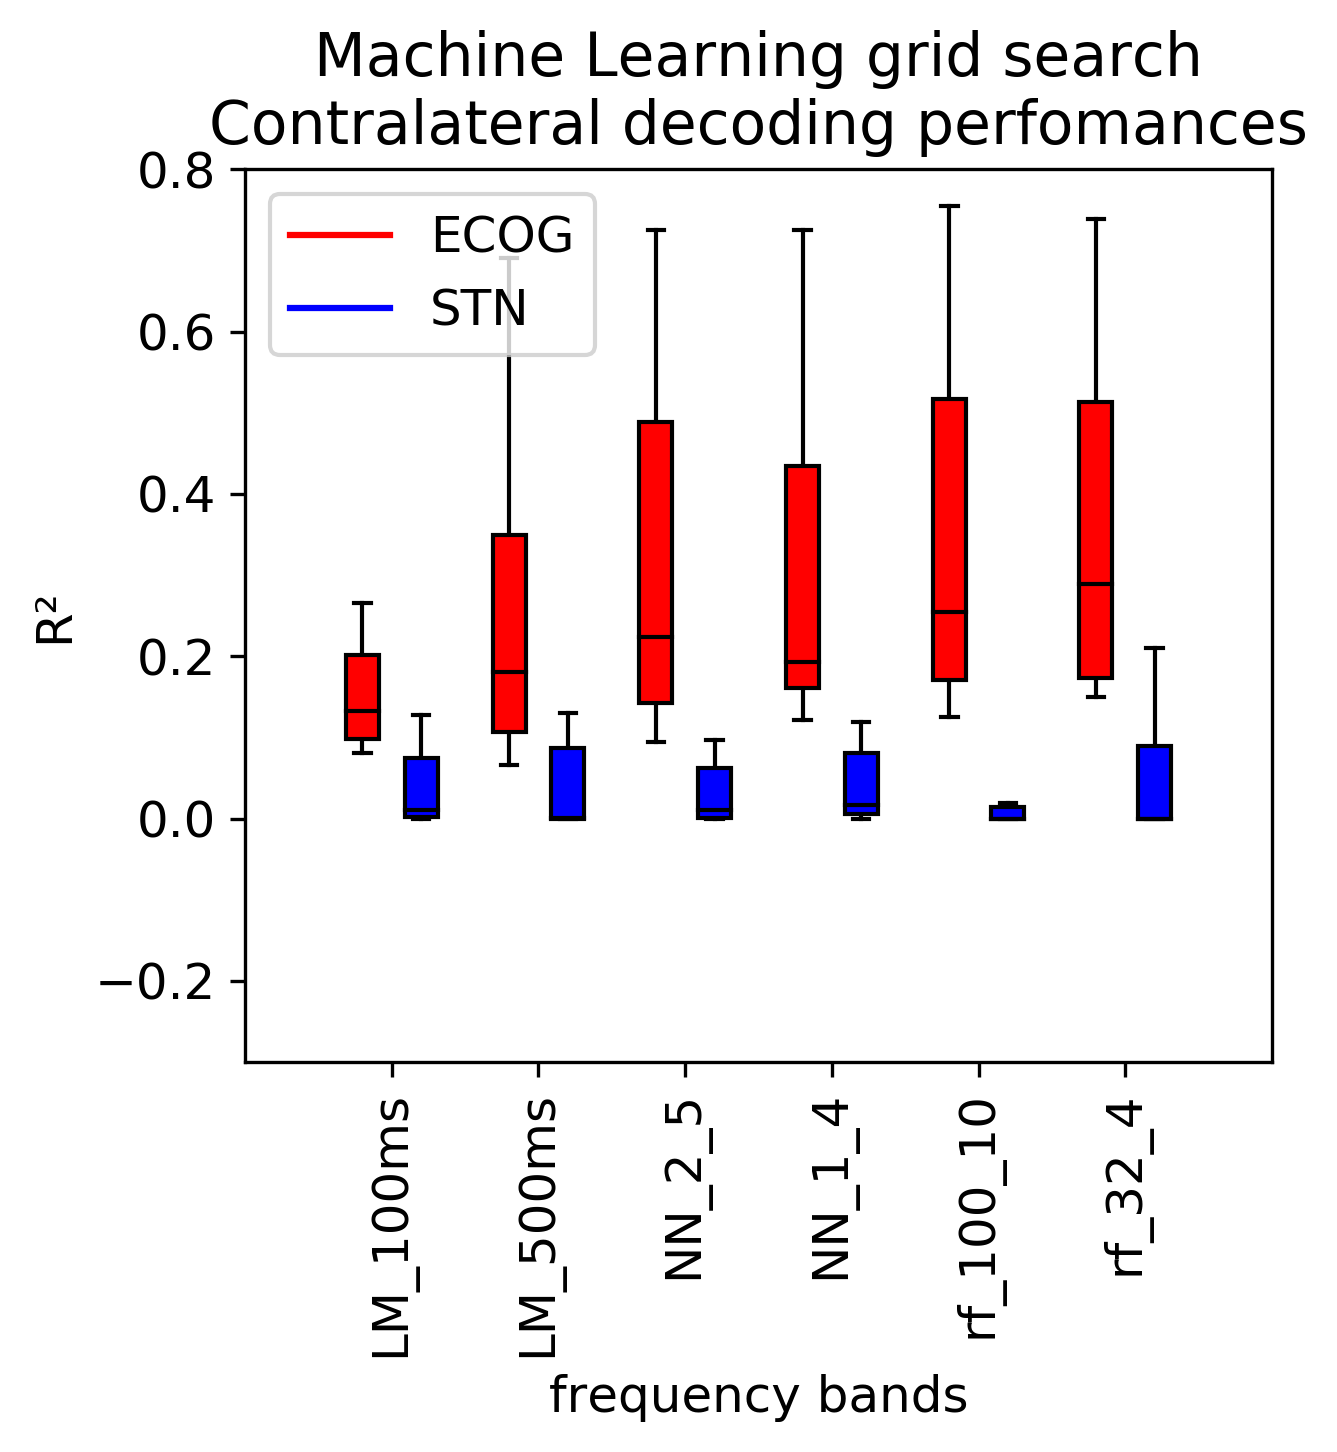

In [77]:
plt.figure(figsize=(4.5,5), dpi=300)
my_box_plot_comparison_here([LM_100ms_con, LM_500ms, NN_2_5, NN_1_4, rf_100_10, rf_32_4_con], \
                           [LM_100ms_stn_con, LM_500ms_stn, NN_2_5_stn, \
                            NN_1_4_stn, rf_100_10_stn, rf_32_4_stn_con], 'ECOG','STN')
plt.legend(loc='upper left')
plt.ylabel('R²')
#plt.grid(True)
#plt.title('spearman\'s correlation coefficient distance channel/hand knob vs AUC performance across channels')
plt.title('Machine Learning grid search\nContralateral decoding perfomances')
plt.ylim(-0.3, 0.8)
plt.tight_layout()

In [16]:
def my_box_plot_comparison(data_a, data_b, num_ =4, label_1 ='raw channel', label_2 ='grid'):
    ticks = [str(i) for i in range(num_)]
    bpl = plt.boxplot(data_a, positions=np.array(range(num_))*2.0-0.4, widths=0.4, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(num_))*2.0+0.4, widths=0.4, patch_artist=True)
    set_box_color(bpl, 'r') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'b')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='r', label=label_1)
    plt.plot([], c='b', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    plt.xticks(range(0, len(ticks) * 2, 2), ['ECOG con', 'ECOG ips', 'STN con', 'STN ips'], rotation=45)
    plt.ylabel('AUC')

ECOG con: 0.36 +-0.21
ECOG ips: 0.17 +-0.18
STN con: 0.11 +-0.21
STN ips: 0.06 +-0.11


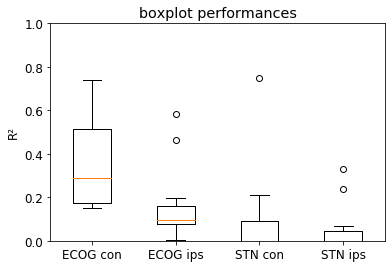

In [17]:
best_ecog_con, best_ecog_ips, best_stn_con, best_stn_ips, l_STN = \
    analyze_mean_res('/home/icn/Documents/raw_out/RF_32_4/', get_weights=False)

In [39]:
res_32_best = {
    "best_ecog_con" : best_ecog_con, 
    "best_ecog_ips" : best_ecog_ips, 
    "best_stn_con" : best_stn_con, 
    "best_stn_ips" : best_stn_ips
}

In [41]:
import pickle

In [42]:
with open('res_32_best.p', 'wb') as handle:
    pickle.dump(res_32_best, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [19]:
best_ecog_con_ = []; best_ecog_ips_ = []
idx = 0
for _, subject_id_ in enumerate(subject_id):
    if subject_id_ in l_STN:
        best_ecog_con_.append(best_ecog_con[idx])
        best_ecog_ips_.append(best_ecog_ips[idx])
        idx+=1
best_ecog_con_ = np.array(best_ecog_con_)
best_ecog_ips_ = np.array(best_ecog_ips_)
best_stn_con = np.array(best_stn_con)
best_stn_ips = np.array(best_stn_ips)

best_stn_con[best_stn_con<-1] = 0
best_stn_ips[best_stn_ips<-1] = 0

In [20]:
best_stn_con.shape

(11,)

In [21]:
stats.ttest_rel(np.arctanh(best_ecog_con_), np.arctanh(best_stn_con))

Ttest_relResult(statistic=4.370835075830779, pvalue=0.001397269834503206)

In [22]:
stats.ttest_rel(np.arctanh(best_ecog_ips_), np.arctanh(best_stn_ips))

Ttest_relResult(statistic=3.5526879225505072, pvalue=0.005244712691224533)

In [23]:
stats.ttest_rel(np.arctanh(best_ecog_con_), np.arctanh(best_ecog_ips_))

Ttest_relResult(statistic=2.649674798974118, pvalue=0.02432663117022535)

In [26]:
stats.ttest_rel(np.arctanh(best_stn_con), np.arctanh(best_stn_ips))

Ttest_relResult(statistic=1.1303616480961338, pvalue=0.28470608673775316)

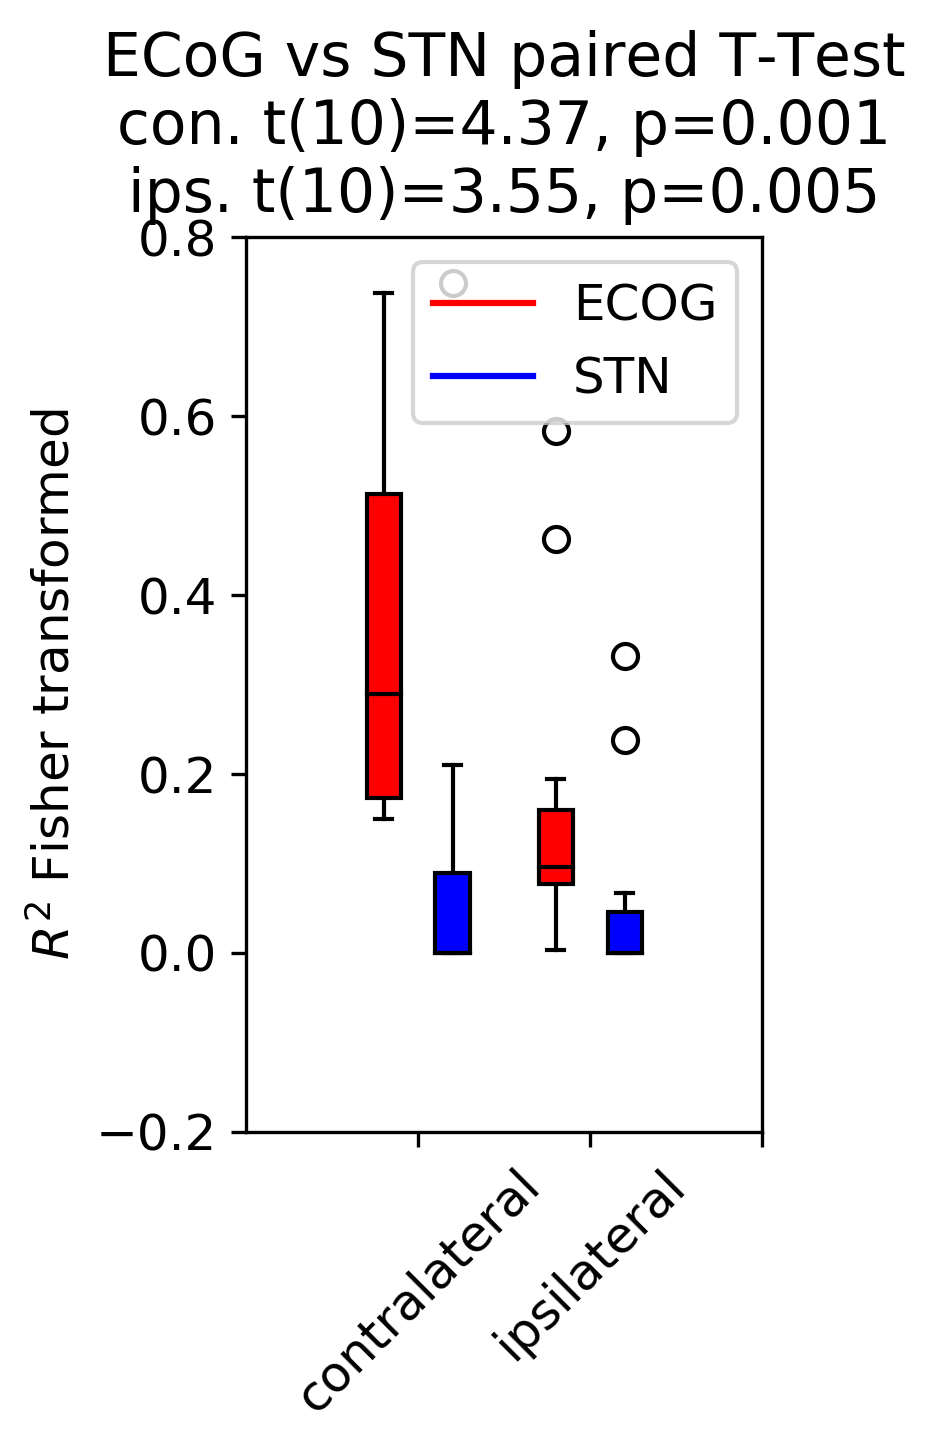

In [114]:

plt.figure(dpi=300, figsize=(3,5))
my_box_plot_comparison([best_ecog_con, best_ecog_ips], [best_stn_con, best_stn_ips], num_ =2, \
    label_1 ='ECOG', label_2 ='STN')

#plt.grid(True)
plt.xticks(range(0, 3*2, 2), ['contralateral', 'ipsilateral'], rotation=45)
#plt.plot([0.5 for i in np.arange(-1, 3*2-2, 1)], label='chance', color='black')
plt.legend()
#plt.title('LM ECoG vs STN con. t(12)=4.22, p=0.001, ips. t(12)=3.03, p=0.01')
plt.title('ECoG vs STN paired T-Test\ncon. t(10)=4.37, p=0.001\nips. t(10)=3.55, p=0.005')
plt.ylim(-0.2, 0.8)
plt.ylabel('$R^2$'+' Fisher transformed')
plt.tight_layout()

plt.show()

### TF-PLOTS

In [ ]:
# calculate average of best TF Plots: ECOG/STN Con/Ips
# for this: 1. get the best channel
# given this channel: load the BIDS file and load the concatenation for that channel
# important: I have already done that! check in VS project 
# then estimate morlet transform 
# this needs to be split for Con and Ips

In [20]:
layout = BIDSLayout(BIDS_path)
tsv_files = layout.get(extension='tsv', return_type='filename')
vhdr_files = layout.get(extension='vhdr', return_type='filename')

In [19]:
def read_BIDS_file(vhdr_file):
    """
    Read one run file from BIDS standard
    :param vhdr_file: 
    :return: raw dataset array, channel name array
    """
    bv_file = mne_bids.read.io.brainvision.read_raw_brainvision(vhdr_file)
    bv_raw = bv_file.get_data()
    return bv_raw, bv_file.ch_names

In [22]:
def get_movement_idx(ch, mov_channels, Con=True):
    """returns index of mov_channels given boolean Con and ch
    
    Arguments:
        ch {string} -- given channel string
        mov_channels {list} -- string list of used movement channels including LEFT or RIGHT
    
    Keyword Arguments:
        Con {bool} -- laterality (default: {True})
    
    Returns:
        int -- index of mov_channel of the lateral channel
    """
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx


In [23]:
def calc_epochs(bv_raw, y_tr, info, threshold, epoch_lim):
     
    ind_mov = np.where(np.diff(np.array(y_tr>threshold)*1) == 1)[0]
    low_limit = ind_mov>epoch_lim
    up_limit = ind_mov < y_tr.shape[0]-epoch_lim
    ind_mov = ind_mov[low_limit & up_limit]
    bv_epoch = np.zeros([ind_mov.shape[0], int(epoch_lim*2)])
    y_arr = np.zeros([ind_mov.shape[0],int(epoch_lim*2)])
    n_epochs = bv_epoch.shape[0]
    events = np.empty((n_epochs, 3), dtype=int)


    event_id = dict(mov_present=1)

    for idx, i in enumerate(ind_mov):
        bv_epoch[idx,:] = bv_raw[i-epoch_lim:i+epoch_lim]
        y_arr[idx,:] = y_tr[i-epoch_lim:i+epoch_lim]
        events[idx,:] = i, 0, event_id["mov_present"]
    print(bv_epoch.shape)
    bv_epoch = np.expand_dims(bv_epoch, axis=1)
    print(bv_epoch.shape)
    epochs = EpochsArray(data=bv_epoch, info=info, events=events, event_id=event_id)
    return epochs

In [24]:
def load_concat_dat(subject_id_, tsv_files, vhdr_files, Con_, ECOG_, out_path='/home/icn/Documents/raw_out/RF_32_4/'):
    """
    This function loads a resulting downsampeled and direct channel cross validated JSON output file 
    From this file the best resulting channel is read 
    According to this channel all raw BIDS run files are searched for that channel 
    Given if this channel contra/ipsilateral the data/movement will concatenated and returned
    :param subject_id_ used BIDS subject id in shape '000'
    :param tsv_files: all TSV Files in the given BIDS folder
    """
    with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        dict_ch = json.load(fp)
    
    best_ch, _ = get_best(dict_ch, Con=Con_, ECOG=ECOG_, get_weights=False)
    
    if best_ch == 'STN_LEFT_3':
        best_ch = 'STN_LEFT_2'
    if best_ch == 'STN_RIGHT_3':
        best_ch = 'STN_RIGHT_2'
    
    print(best_ch)
    if 'RIGHT' in best_ch:
        ses_patient = 'right'
    elif 'LEFT' in best_ch :
        ses_patient = 'left'
    
    #ses_ = []
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-right')) is True:
    #    ses_.append('right')
    #if os.path.exists(os.path.join(BIDS_path, 'sub-'+subject_id, 'ses-left')) is True:
    #    ses_.append('left')
    #print(ses_patient)
    runs_ = [file for file in tsv_files if 'sub-'+subject_id_ in file and 'ses-'+ses_patient in file and file.endswith('channels.tsv')]
    start = 0
    #print(runs_)
    for run in runs_:
        #print(run)
        df_run = pd.read_csv(run, sep="\t")
        if best_ch in list(df_run['name']):
            ind_data = np.where(df_run['name'] == best_ch)[0][0]
            run_number = run[run.find('run-')+4:run.find('_channels')] # is a string
            
            vhdr_file = 'sub-'+subject_id_+'_ses-'+ses_patient+'_task-force_run-'+str(run_number)+'_eeg.vhdr'
            vhdr_path = [file for file in vhdr_files if vhdr_file in file][0]
                
            #print(vhdr_path)
            
            bv_raw, ch_names = read_BIDS_file(vhdr_path)

            ind_mov = [ch_idx for ch_idx, ch in enumerate(ch_names) if ch.startswith('MOV') or ch.startswith('ANALOG')]

            # approach only indexing ECOG named channels
            ind_dat = np.arange(bv_raw.shape[0])[~np.isin(np.arange(bv_raw.shape[0]), ind_mov)]
            
            #print(ind_mov)
            mov_label = bv_raw[ind_mov, :] 
            
            #print(ch_names)
            mov_channels = list(np.array(ch_names)[ind_mov])
            
            mov_idx = get_movement_idx(best_ch, mov_channels, Con=Con_)
            
            print('best_ch: '+str(best_ch))
            print('mov_channels: '+str(mov_channels))
            print('mov_idx: '+str(mov_idx))
            label_ = mov_label[mov_idx,:]

            if start == 0: 
                start = 1 
                ch_dat = bv_raw[ind_data,:]
                mov_dat = label_
            else:
                ch_dat = np.concatenate((ch_dat, bv_raw[ind_data,:]), axis=0)
                mov_dat = np.concatenate((mov_dat, label_), axis=0)
    return best_ch, ch_dat, mov_dat


In [79]:
def get_best_ch_t_f(Con_, ECOG_, plot_ = False, n_cycles =5):
    """
    estimate for all patients the time onset locked time frequency plot (mean over all movement epochs)
    """
    
    dat_all = []
    idx_here = 0
    for _, subject_id_ in enumerate(subject_id):
        if subject_id_ in subject_exclude:
            continue
        if Con_ is False and subject_id_ == '016':
            continue
        if Con_ is False and subject_id_ == '013':
            continue
        print(subject_id_)
        best_ch, ch_dat, mov_dat = \
            load_concat_dat(subject_id_, tsv_files, vhdr_files, Con_=Con_, \
            ECOG_=ECOG_, out_path='/home/icn/Documents/raw_out/RF_32_4/')
        mov_dat = scipy.stats.zscore(mov_dat)
        if subject_id_ == '016':
            mov_dat = -mov_dat
            dat_points = ch_dat.shape[0]
            new_num_data_points = int((dat_points/1375)*1000)
            ch_dat = signal.resample(ch_dat, num=new_num_data_points, axis=0)
            mov_dat = signal.resample(mov_dat, num=new_num_data_points, axis=0)
        # z-score mov_dat and then apply the threshold 
        mov_dat = scipy.stats.zscore(mov_dat, axis=0)
        sfreq = 1000
        info = create_info(ch_names=[best_ch], sfreq=sfreq, ch_types='ecog')
        epochs = calc_epochs(ch_dat, mov_dat, info, threshold=1.5, epoch_lim=1500)

        
        freqs = np.arange(7, 200, 1)
        power = tfr_morlet(epochs, freqs=freqs,
                               n_cycles=n_cycles, return_itc=False, zero_mean=True, picks=0, n_jobs=20)
        dat = power.data[0,:,500:2500]  # cut off borders due to Wavelet transform
        dat_z = scipy.stats.zscore(dat, axis=1)
        
        dat_all.append(dat_z)
        idx_here +=1
        if plot_ is True:
            plt.figure(figsize=(15,5))
            #plt.subplot(1,6,ch_idx+1)
            plt.imshow(dat_z, aspect='auto', extent=[-2,2,200,0])
            #plt.colorbar()
            plt.clim(-1,1)
            plt.gca().invert_yaxis()
            plt.title(best_ch)
            plt.tight_layout()
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [s]')
            plt.show()
    return np.array(dat_all)

In [80]:
tf_ecog_ips = get_best_ch_t_f(Con_ = False, ECOG_ = True, plot_ = False, n_cycles =7)
tf_ecog_con = get_best_ch_t_f(Con_ = True, ECOG_ = True, plot_ = False, n_cycles =7)
tf_stn_con = get_best_ch_t_f(Con_ = True, ECOG_ = False, plot_ = False, n_cycles =7)
tf_stn_ips = get_best_ch_t_f(Con_ = False, ECOG_ = False, plot_ = False, n_cycles =7)

000
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(59, 3000)
(59, 1, 3000)
59 matching events found
No baseline correctio

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.3s finished


001
ECOG_LEFT_23
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_23
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-00

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    8.9s finished


004
ECOG_RIGHT_3
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(56, 3000)
(56, 1, 3000)
56 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.0s finished


005
ECOG_LEFT_5
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(97, 3000)
(97, 1, 3000)
97 matching events found
No baseline correction applied
Not

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    7.0s finished


006
ECOG_LEFT_14
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_14
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 3000)
(85, 1, 3000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
ECOG_LEFT_3
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_3
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(40, 3000)
(40, 1, 3000)
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    6.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.9s finished


008
ECOG_LEFT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(88, 3000)
(88, 1, 3000)
88 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


009
ECOG_LEFT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    6.4s finished


best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(54, 3000)
(54, 1, 3000)
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.9s finished


010
ECOG_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   15.0s finished


014
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(69, 3000)
(69, 1, 3000)
69 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.0s finished


000
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(59, 3000)
(59, 1, 3000)
59 matching events found
No baseline correctio

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.3s finished


001
ECOG_RIGHT_19
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-right/eeg/sub-001_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-right/eeg/sub-001_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-right/eeg/sub-001_ses-right_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_19
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(100, 3000)
(100, 1, 3000)
100 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    7.5s finished


004
ECOG_RIGHT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_4
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(65, 3000)
(65, 1, 3000)
65 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.7s finished


005
ECOG_LEFT_6
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_6
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(100, 3000)
(100, 1, 3000)
100 matching events found
No baseline correction applied


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    7.4s finished


006
ECOG_RIGHT_18
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-6_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_18
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(112, 3000)
(112, 1, 3000)
112 matching events found
No baseline c

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
ECOG_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(41, 3000)
(41, 1, 3000)
41 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    8.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


008
ECOG_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.0s finished


best_ch: ECOG_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(97, 3000)
(97, 1, 3000)
97 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


009
ECOG_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    7.5s finished


best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(72, 3000)
(72, 1, 3000)
72 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.2s finished


010
ECOG_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


013
ECOG_LEFT_5
Extracting parameters from /home/icn/Documents/BIDS/sub-013/ses-left/eeg/sub-013_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
Extracting parameters from /home/icn/Documents/BIDS/sub-013/ses-left/eeg/sub-013_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:   10.5s finished


best_ch: ECOG_LEFT_5
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(33, 3000)
(33, 1, 3000)
33 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.0s finished


014
ECOG_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(88, 3000)
(88, 1, 3000)
88 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    6.4s finished


016
ECOG_LEFT_4
Extracting parameters from /home/icn/Documents/BIDS/sub-016/ses-left/eeg/sub-016_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: ECOG_LEFT_4
mov_channels: ['MOV_RIGHT']
mov_idx: 0
(51, 3000)
(51, 1, 3000)
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.8s finished


000
STN_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(21, 3000)
(21, 1, 3000)
21 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.6s finished


001
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(39, 3000)
(39, 1, 3000)
39 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.9s finished


004
STN_RIGHT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(42, 3000)
(42, 1, 3000)
42 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.6s finished


005
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(44, 3000)
(44, 1, 3000)
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.2s finished


006
STN_RIGHT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-right/eeg/sub-006_ses-right_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(23, 3000)
(23, 1, 3000)
23 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(41, 3000)
(41, 1, 3000)
41 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    5.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


008
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.0s finished


best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(51, 3000)
(51, 1, 3000)
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


009
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    4.2s finished


best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(8, 3000)
(8, 1, 3000)
8 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.6s finished


010
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(33, 3000)
(33, 1, 3000)
33 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


013
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-013/ses-left/eeg/sub-013_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(18, 3000)
(18, 1, 3000)
18 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.0s finished


014
STN_RIGHT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(30, 3000)
(30, 1, 3000)
30 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.2s finished


016
STN_LEFT_6
Extracting parameters from /home/icn/Documents/BIDS/sub-016/ses-left/eeg/sub-016_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_6
mov_channels: ['MOV_RIGHT']
mov_idx: 0
(51, 3000)
(51, 1, 3000)
51 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.9s finished


000
STN_RIGHT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(22, 3000)
(22, 1, 3000)
22 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.7s finished


001
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-7_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(37, 3000)
(37, 1, 3000)
37 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.7s finished


004
STN_RIGHT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-004/ses-right/eeg/sub-004_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(40, 3000)
(40, 1, 3000)
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.0s finished


005
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-005/ses-left/eeg/sub-005_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(43, 3000)
(43, 1, 3000)
43 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.1s finished


006
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-3_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
Extracting parameters from /home/icn/Documents/BIDS/sub-006/ses-left/eeg/sub-006_ses-left_task-force_run-5_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(85, 3000)
(85, 1, 3000)
85 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


007
STN_LEFT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-007/ses-left/eeg/sub-007_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(40, 3000)
(40, 1, 3000)
40 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


008
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-008/ses-left/eeg/sub-008_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    2.9s finished


best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(41, 3000)
(41, 1, 3000)
41 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


009
STN_LEFT_1
Extracting parameters from /home/icn/Documents/BIDS/sub-009/ses-left/eeg/sub-009_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...


[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.0s finished


best_ch: STN_LEFT_1
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(5, 3000)
(5, 1, 3000)
5 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.4s finished


010
STN_LEFT_2
Extracting parameters from /home/icn/Documents/BIDS/sub-010/ses-left/eeg/sub-010_ses-left_task-force_run-4_eeg.vhdr...
Setting channel info structure...
best_ch: STN_LEFT_2
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 1
(54, 3000)
(54, 1, 3000)
54 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    3.9s finished


014
STN_RIGHT_0
Extracting parameters from /home/icn/Documents/BIDS/sub-014/ses-right/eeg/sub-014_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
best_ch: STN_RIGHT_0
mov_channels: ['MOV_RIGHT', 'MOV_LEFT']
mov_idx: 0
(24, 3000)
(24, 1, 3000)
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.8s finished


In [90]:
def plot_all_tf(tf__):
    
    for idx in range(tf__.shape[0]):
        plt.subplot(4,3,idx+1)
        #plt.subplot(1,6,ch_idx+1)
        plt.imshow(tf__[idx,:,:], aspect='auto', extent=[-1,1,200,0])
        #plt.colorbar()
        plt.clim(-1,1)
        plt.gca().invert_yaxis()
        plt.title(subject_tf_usage[idx])
        plt.tight_layout()
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
    plt.tight_layout()
    plt.show()


In [92]:
tf_stn_ips.shape

(10, 193, 2000)

tf_ecog_con


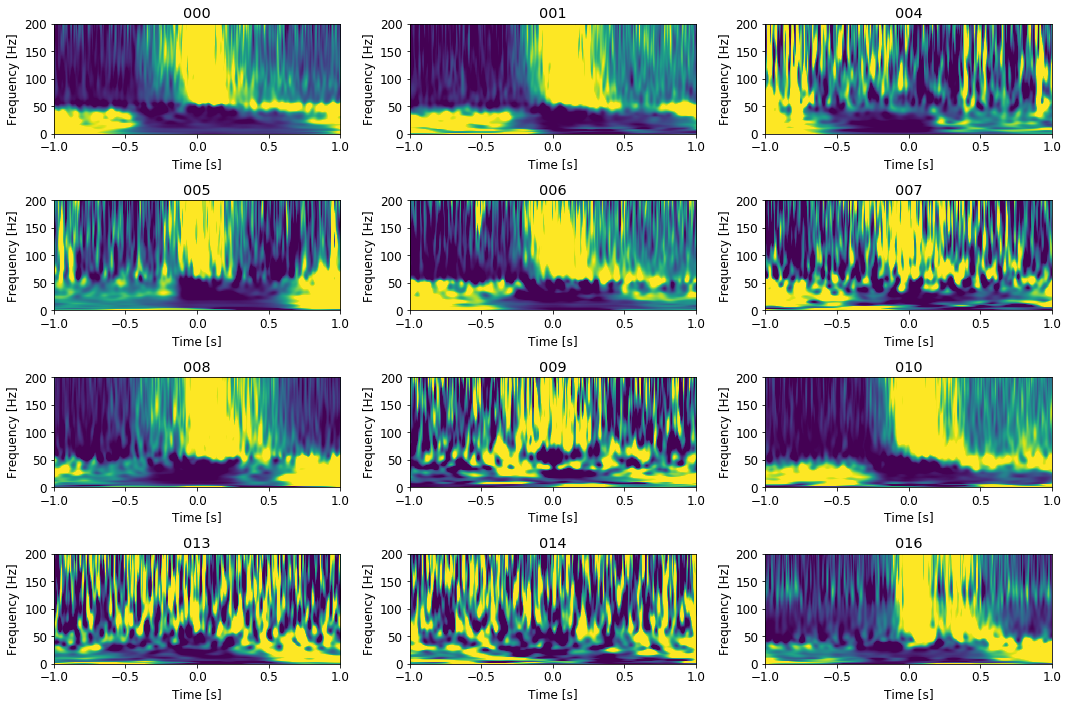

tf_ecog_ips


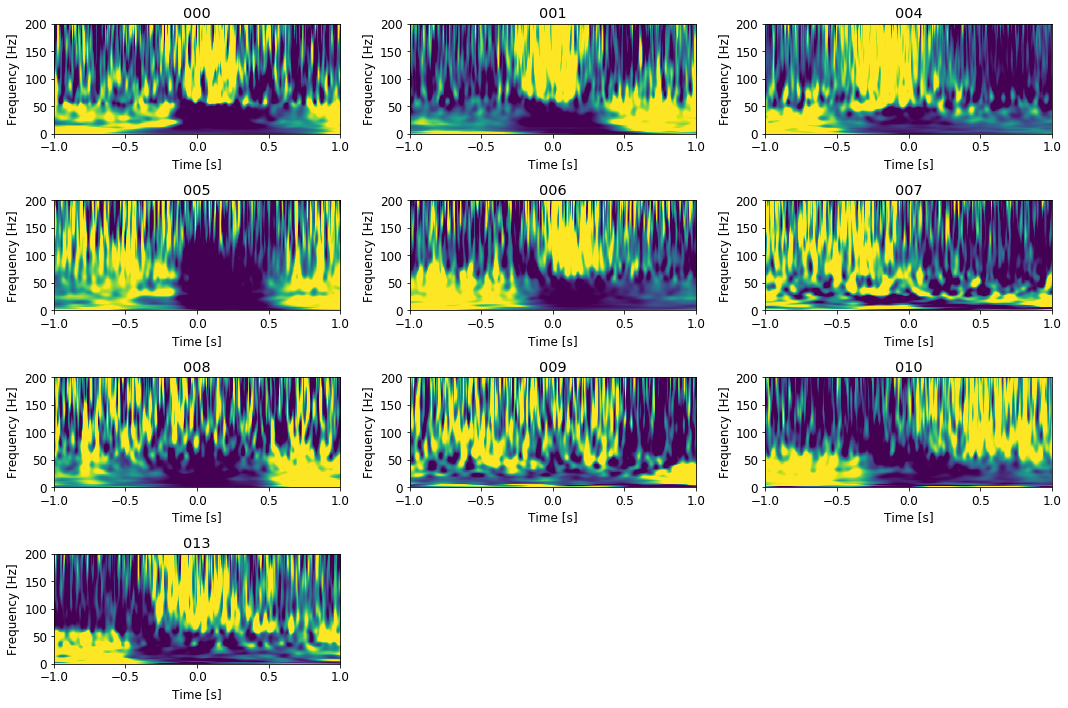

tf_stn_con


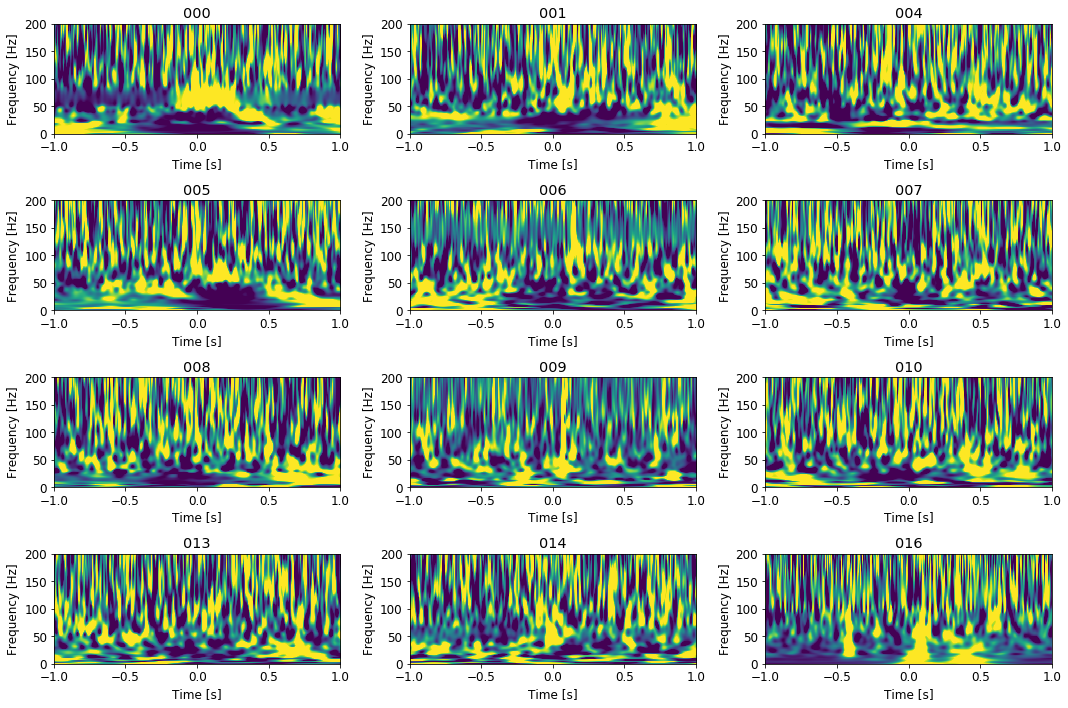

tf_stn_ips


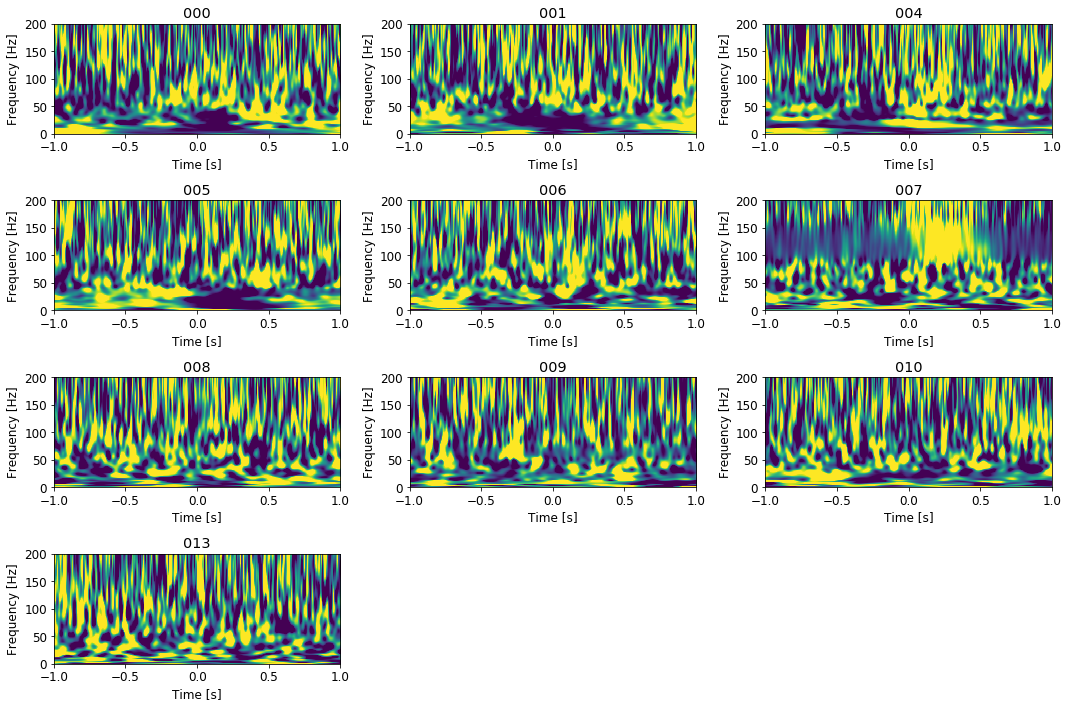

In [91]:
print('tf_ecog_con')
plt.figure(figsize=(15,10))
plot_all_tf(tf_ecog_con)
print('tf_ecog_ips')
plt.figure(figsize=(15,10))
plot_all_tf(tf_ecog_ips)
print('tf_stn_con')
plt.figure(figsize=(15,10))
plot_all_tf(tf_stn_con)
print('tf_stn_ips')
plt.figure(figsize=(15,10))
plot_all_tf(tf_stn_ips)

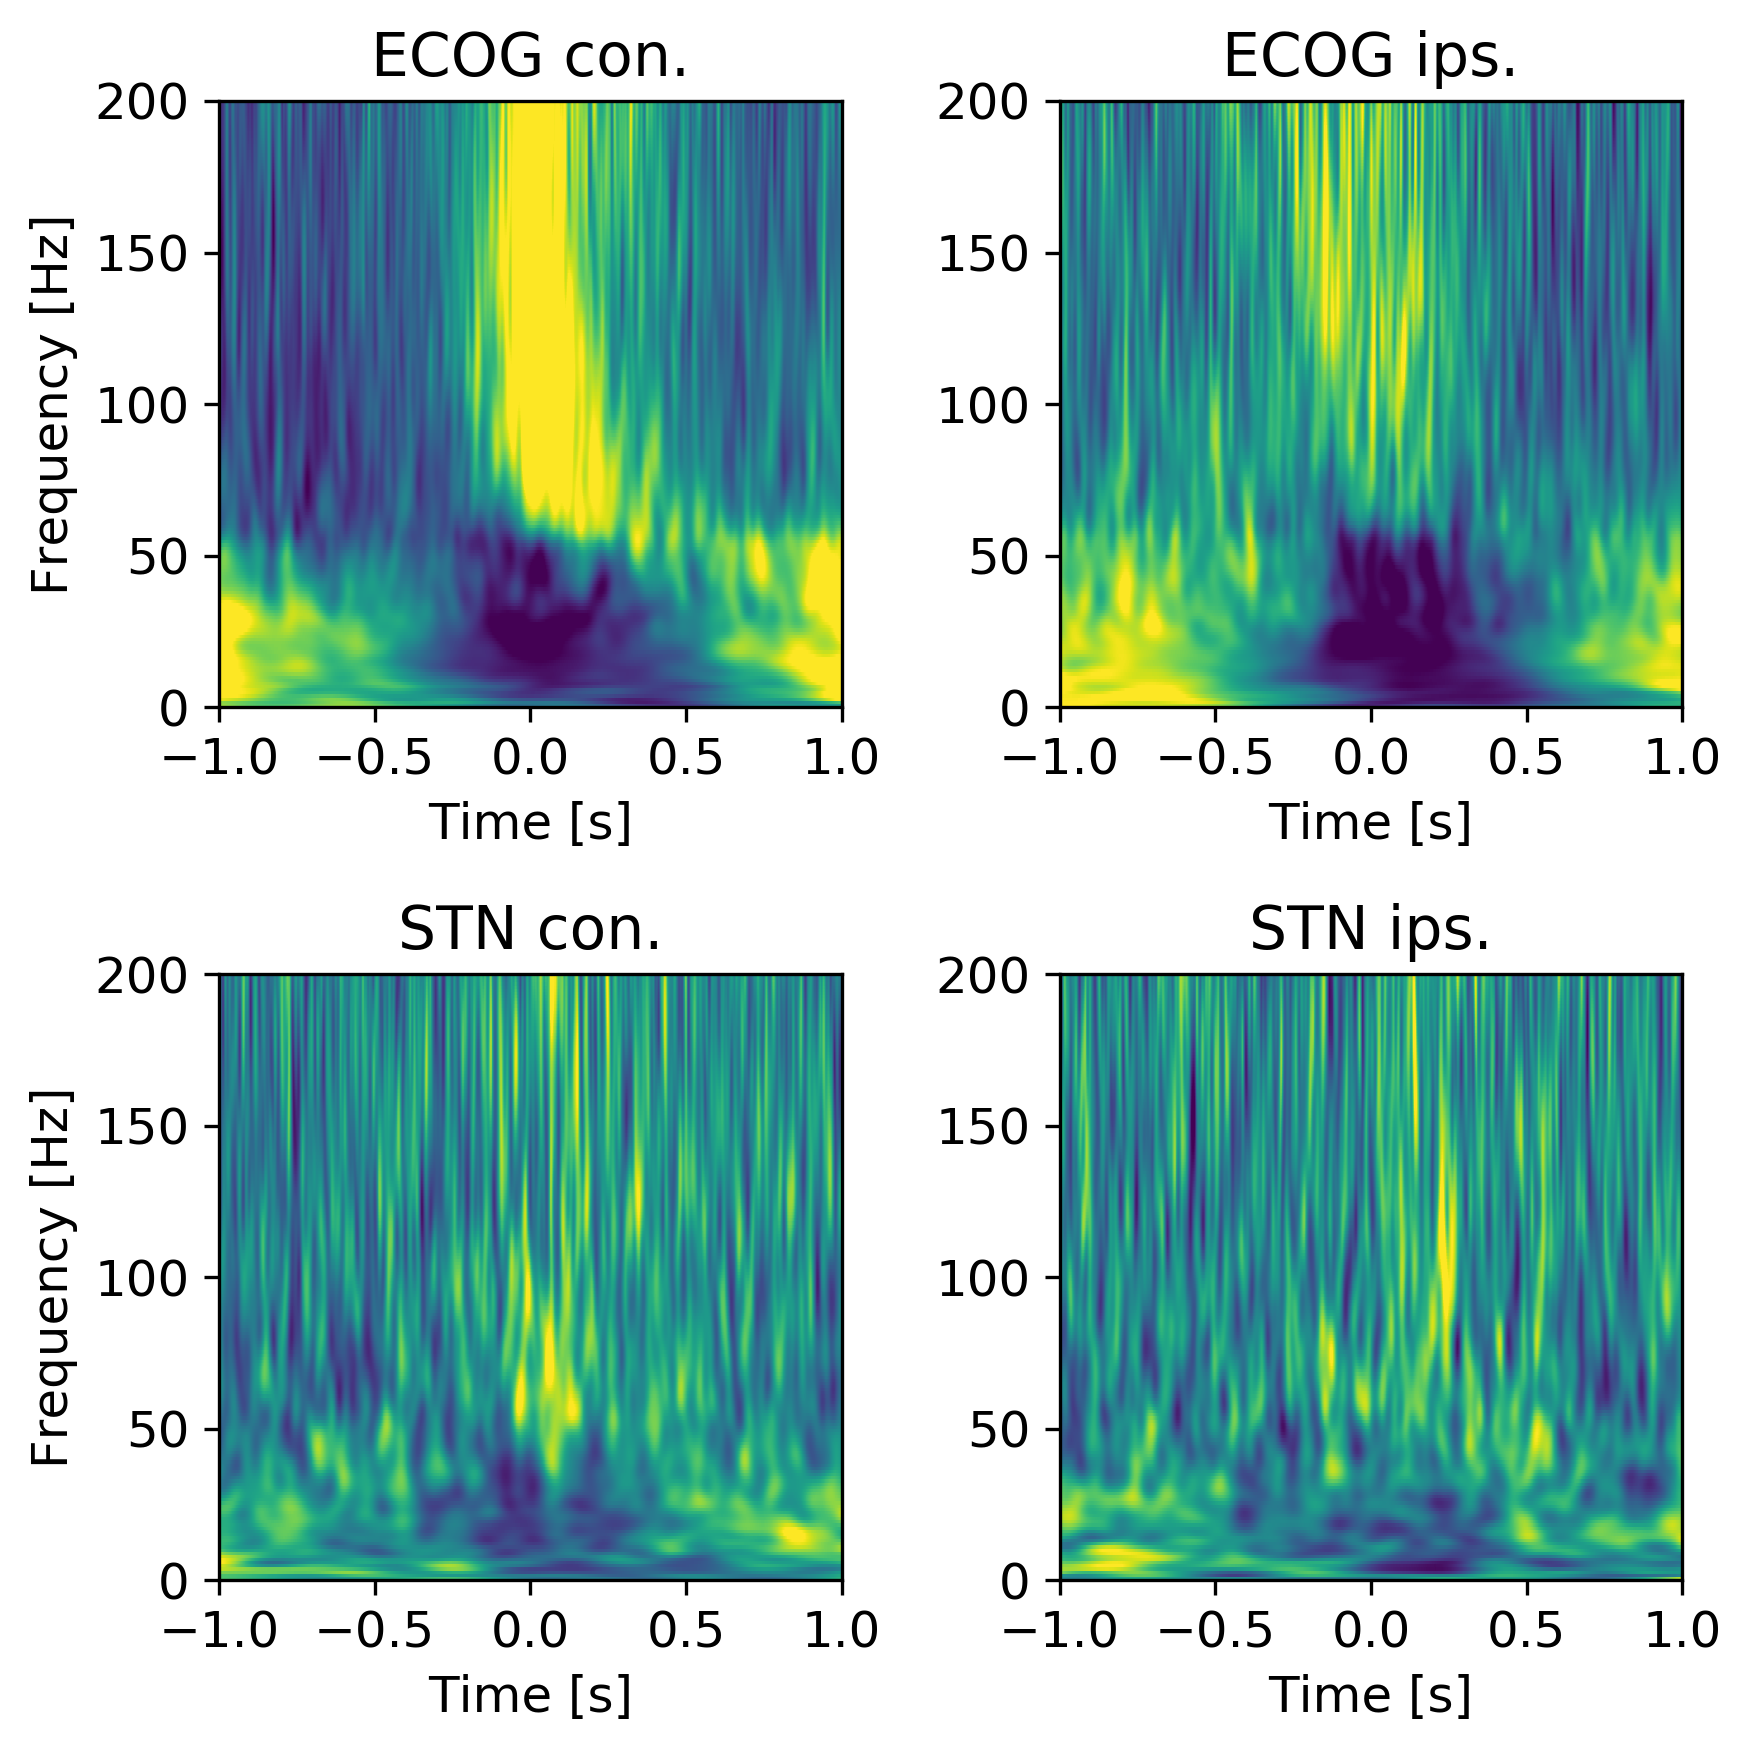

In [82]:
title = ['ECOG con.', 'ECOG ips.', \
        'STN con.', 'STN ips.']
plt.figure(figsize=(6,6), dpi=300)
for idx, dat_ in enumerate([np.mean(tf_ecog_con, axis=0), np.mean(tf_ecog_ips, axis=0), np.mean(tf_stn_con, axis=0), np.mean(tf_stn_ips, axis=0)]):
    plt.subplot(2,2,idx+1)
    plt.imshow(dat_, aspect='auto', extent=[-1,1,200,0])#, cmap='hot')
    #plt.colorbar()
    plt.clim(-1,1)
    plt.gca().invert_yaxis()
    plt.title(title[idx])
    if idx == 0 or idx == 2:
        plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
plt.tight_layout()

### time plot epochs

In [ ]:
#hier müssen die schon T-F transformierten Bänder (8 Bänder) ermittelt werden, und als input feature genutzt
#werden

In [44]:
def get_all_epochs(Con_ = True, ECOG_ = False, epoch_lim=10, threshold=1):
    epochs_true = []; epochs_pred = []
    for _, subject_id_ in enumerate(subject_id):
        if subject_id_ in subject_exclude:
            continue
        if Con_ is False and subject_id_ == '016':
            continue
        print(subject_id_)
        
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
        
        best_ch, best_acc, X, mov_dat = get_best(dict_ch, Con=Con_, ECOG=ECOG_, get_weights=False, get_data=True)
        
        if subject_id_ == '016':
            mov_dat = -mov_dat
        
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X.T, mov_dat, test_size=0.33, shuffle=False)
        X_train, y_train = append_time_dim(X_train, y_train, time_stamps=5)
        X_test, y_test = append_time_dim(X_test, y_test, time_stamps=5)
        model_ = ensemble.RandomForestRegressor(n_estimators=32, max_depth=4, n_jobs=-1)
        model_ = model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)
        
        ind_mov = np.where(np.diff(np.array(y_test>threshold)*1) == 1)[0]
        low_limit = ind_mov>epoch_lim
        up_limit = ind_mov < y_test.shape[0]-epoch_lim
        ind_mov = ind_mov[low_limit & up_limit]
        y_pred_epoch = np.zeros([ind_mov.shape[0], 20])
        y_true_arr = np.zeros([ind_mov.shape[0], 20])

        for idx, i in enumerate(ind_mov):
            y_pred_epoch[idx,:] = y_pred[i-epoch_lim:i+epoch_lim]
            y_true_arr[idx,:] = y_test[i-epoch_lim:i+epoch_lim]
        
        epochs_true.append(y_true_arr)
        epochs_pred.append(y_pred_epoch)
    return epochs_true, epochs_pred

In [45]:
def get_concat_epochs(epochs_):
    epoch_pr = epochs_[1][0]
    epoch_true = epochs_[0][0]
    for patient_idx in range(1,len(epochs_[0])):
        if epochs_[0][patient_idx].shape[0] !=0:
            epoch_pr = np.concatenate((epoch_pr, epochs_[1][patient_idx]))
            epoch_true = np.concatenate((epoch_true, epochs_[0][patient_idx]))
    return epoch_pr, epoch_true

In [48]:
epochs_ecog_con = get_all_epochs(Con_ = True, ECOG_ = True)
epochs_ecog_ips = get_all_epochs(Con_ = False, ECOG_ = True)
epochs_stn_con = get_all_epochs(Con_ = True, ECOG_ = False)
epochs_stn_ips = get_all_epochs(Con_ = False, ECOG_ = False)

000
001
004
005
006
007
008
009
010
013
014
016
000
001
004
005
006
007
008
009
010
013
014
000
001
004
005
006
007
008
009
010
013
014
016
000
001
004
005
006
007
008
009
010
013
014


In [51]:
def plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10):

    xlab = np.round(np.arange(-epoch_lim, epoch_lim, 5)*0.1,2)
    plt.title('Contralateral movements')
    plt.plot(epoch_pr.mean(axis=0), color='r',label='predict')
    plt.plot(epoch_true.mean(axis=0), color='b',label='true')
    #plt.errorbar(np.arange(epoch_pr.shape[1]), epoch_pr.mean(axis=0), epoch_pr.std(axis=0), \
    #            label='predict', alpha=0.5, color='r')
    #plt.errorbar(np.arange(epoch_true.shape[1]), epoch_true.mean(axis=0), epoch_true.std(axis=0), \
    #             label='true', alpha=0.5, color='b')
    plt.fill_between(np.arange(epoch_pr.shape[1]), epoch_pr.mean(axis=0)-epoch_pr.std(axis=0), \
                epoch_pr.mean(axis=0)+epoch_pr.std(axis=0), alpha=0.5, color='r')
    plt.fill_between(np.arange(epoch_true.shape[1]), epoch_true.mean(axis=0)-epoch_true.std(axis=0), \
                epoch_true.mean(axis=0)+epoch_true.std(axis=0), alpha=0.5, color='b')

    plt.xticks(np.arange(0,epoch_lim*2,5), xlab)
    plt.xlabel('Time [s]')
    plt.ylim(-0.5, 5)
    plt.legend(loc='upper left')

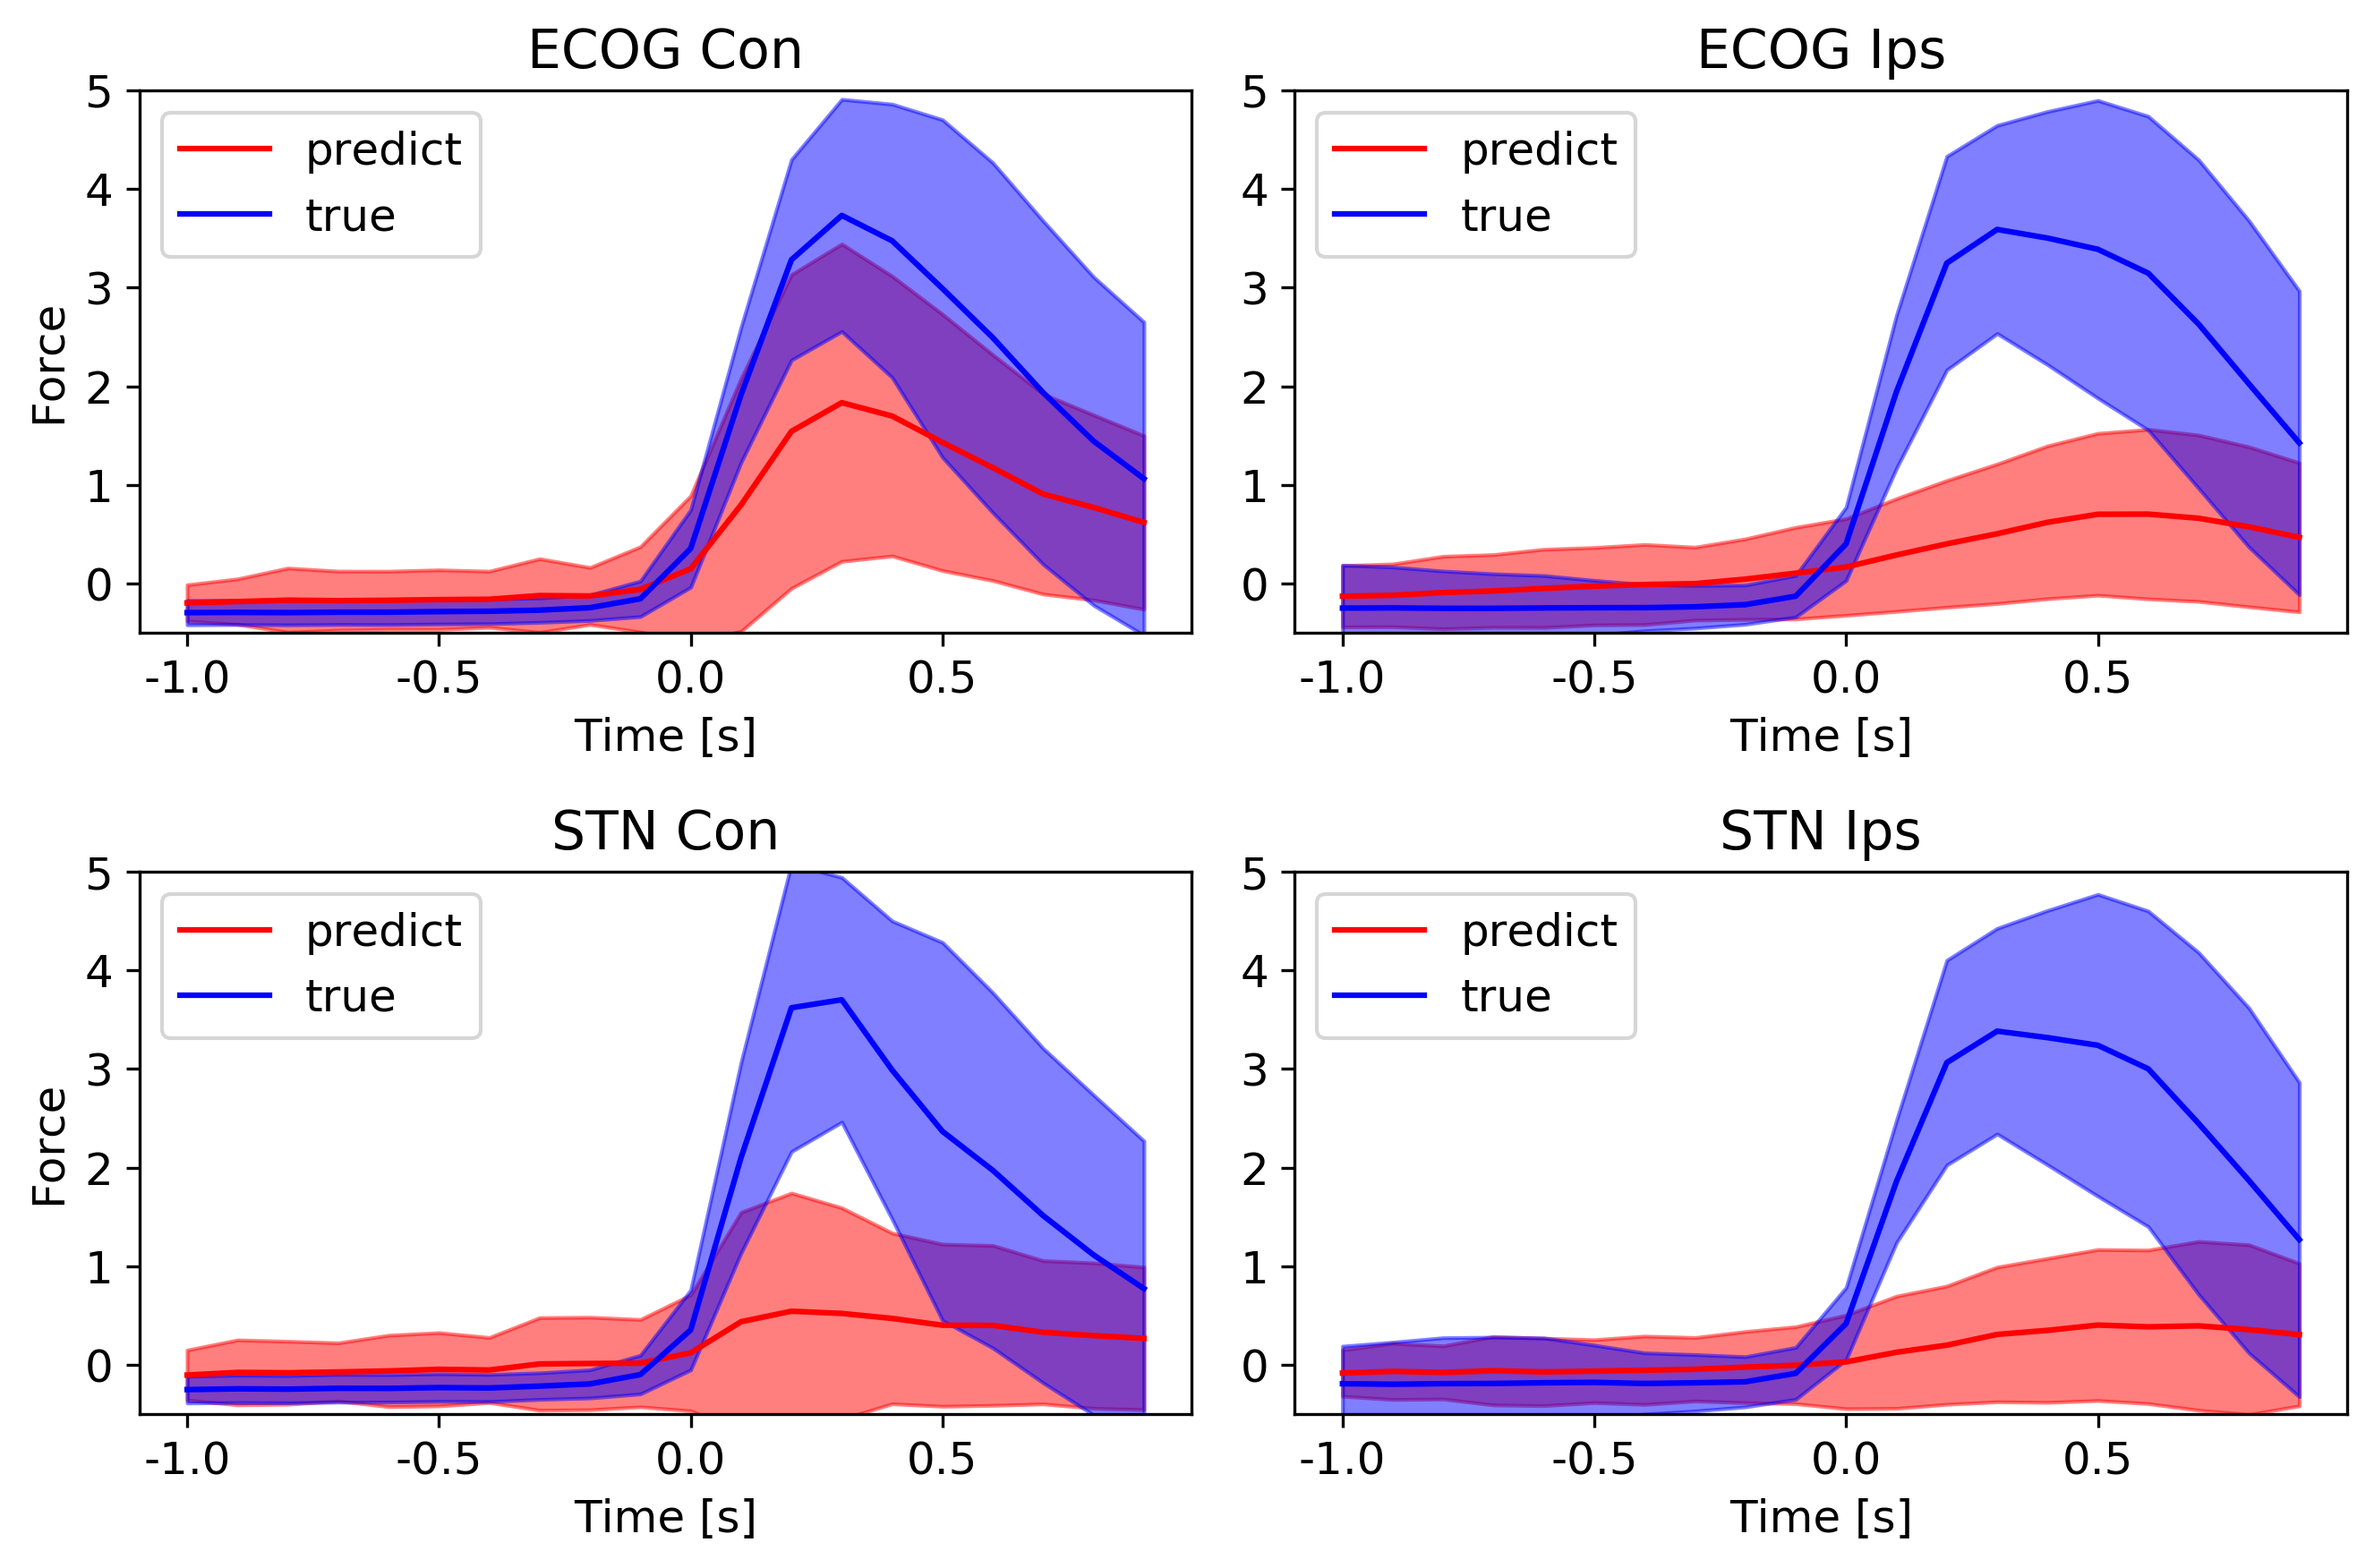

In [52]:
plt.figure(figsize=(9,6), dpi=300)
plt.subplot(2,2,1)
epoch_pr, epoch_true = get_concat_epochs(epochs_ecog_con)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
plt.title('ECOG Con'); plt.ylabel('Force')

plt.subplot(2,2,2)
epoch_pr, epoch_true = get_concat_epochs(epochs_ecog_ips)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
plt.title('ECOG Ips')

plt.subplot(2,2,3)
epoch_pr, epoch_true = get_concat_epochs(epochs_stn_con)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
plt.title('STN Con'); plt.ylabel('Force')

plt.subplot(2,2,4)
epoch_pr, epoch_true = get_concat_epochs(epochs_stn_ips)
plot_mov_epochs(epoch_pr, epoch_true, epoch_lim = 10)
plt.title('STN Ips')
plt.tight_layout()

## Comparison best channel ECOG vs best ECOG AND best STN channel combined

In [ ]:
### so far: best ECOG and best STN channel is known
# try to combine both: take only runs, in which both are present
# here: use raw_runs 
# the best channels are for both known
# IMPORTANT: the run number is also different... take only runs were really both is present? 

# 1. get best ch for ECOG and STN 
# 2. run through every run_ch file and load from folder "raw_runs" the respective channels 
# append time 

# run a 5fold CV to estimate performance and compare with best accuracy determined elsewise (ECOG/STN)
# question here: does ECOG get better? 

In [31]:
best_ch_STN, best_acc = get_best(dict_ch, Con=True, ECOG=False, get_weights=False, get_data=False)
best_ch_ECOG, best_acc = get_best(dict_ch, Con=True, ECOG=True, get_weights=False, get_data=False)

NameError: name 'dict_ch' is not defined

In [329]:
def load_concat_best_ECOG_best_STN(subject_id_, Con_, \
                                   out_path='/home/icn/Documents/raw_out/RF_32_4/', \
                                   path_runs='/home/icn/Documents/raw_out/raw_runs/'):
    """
    This function loads a resulting downsampeled and direct channel cross validated JSON output file 
    From this file the best resulting channel is read 
    According to this channel all raw BIDS run files are searched for that channel 
    Given if this channel contra/ipsilateral the data/movement will concatenated and returned
    :param subject_id_ used BIDS subject id in shape '000'
    :param tsv_files: all TSV Files in the given BIDS folder
    """
    with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
        dict_ch = json.load(fp)
    print(subject_id_)
    best_ch_STN, best_acc = get_best(dict_ch, Con=Con_, ECOG=False, get_weights=False, get_data=False)
    best_ch_ECOG, best_acc = get_best(dict_ch, Con=Con_, ECOG=True, get_weights=False, get_data=False)
    
    if ('RIGHT' in best_ch_STN) and ('LEFT' in best_ch_ECOG):
        best_ch_ECOG, best_acc = get_best(dict_ch, Con=not Con_, ECOG=True, get_weights=False, get_data=False)
    if ('LEFT' in best_ch_STN) and ('RIGHT' in best_ch_ECOG):
        best_ch_ECOG, best_acc = get_best(dict_ch, Con=not Con_, ECOG=True, get_weights=False, get_data=False)

    
    if 'RIGHT' in best_ch_STN:
        ses_patient = 'right'
    elif 'LEFT' in best_ch_STN :
        ses_patient = 'left'
    
    
    raw_runs = os.listdir(path_runs)
    runs_ = [os.path.join(path_runs, file) for file in raw_runs if subject_id_ in file and ses_patient in file]
    print(runs_)
    print(best_ch_ECOG)
    print(best_ch_STN)
    start = 0

    for run in runs_:
        with open(run, 'r') as fp:
            dict_ = json.load(fp)
            ch_names = dict_['ch_names']
            print(ch_names)
        if best_ch_STN in ch_names:

            ind_mov = [ch_idx for ch_idx, ch in enumerate(ch_names) if ch.startswith('MOV') or ch.startswith('ANALOG')]

            # approach only indexing ECOG named channels
            ind_STN = np.where(np.array(ch_names) == best_ch_STN)[0][0]
            ind_ECOG = np.where(np.array(ch_names) == best_ch_ECOG)[0][0]

            #print(ind_mov)
            mov_label = np.array(dict_['true_movements'])

            #print(ch_names)
            mov_channels = list(np.array(ch_names)[ind_mov])
            
            mov_idx = get_movement_idx(best_ch_STN, mov_channels, Con=Con_)

            label_ = mov_label[mov_idx,:]
            
            if start == 0: 
                start = 1 
                ch_dat = np.array(dict_['data'])[:,[ind_ECOG, ind_STN],:]
                mov_dat = label_
            else:
                ch_dat = np.concatenate((ch_dat, np.array(dict_['data'])[:,[ind_ECOG, ind_STN],:]), axis=2)
                mov_dat = np.concatenate((mov_dat, label_), axis=0)
    return ch_dat, mov_dat


In [363]:
def get_ECOG_n_STN_res(Con_ = True):
    res_ = []
    for subject_id_ in subject_id:
        if subject_id_ in subject_exclude:
            continue
        ch_dat, mov_dat = load_concat_best_ECOG_best_STN(subject_id_, Con_, \
                                           out_path='/home/icn/Documents/raw_out/RF_32_4_with_AUC/', \
                                           path_runs='/home/icn/Documents/raw_out/raw_runs/')
        ch_dat = ch_dat.reshape((16, ch_dat.shape[2]), order='F')
        X,y = append_time_dim(ch_dat.T, mov_dat, time_stamps=5)
        model = ensemble.RandomForestRegressor(n_estimators=32, max_depth=4)
        res_.append(np.mean(cross_val_score(model, X, y, scoring='r2', cv=5, n_jobs=-1)))
    res_ = np.array(res_)
    res_[res_<0] = 0
    return res_

In [ ]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        if ECOG is True and 'STN' in ch:
            continue
        elif ECOG is False and 'ECOG' in ch:
            continue
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]]['R2']
        mov_idx_[counter_ch] = mov_idx
        counter_ch += 1

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, best_acc, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    return best_ch, best_acc, best_weights

In [369]:
stats.ttest_rel(np.arctanh(direct_ECOG_con), np.arctanh(con_res))

Ttest_relResult(statistic=1.6498304162223294, pvalue=0.1272118581304366)

In [370]:
stats.ttest_rel(np.arctanh(direct_ECOG_ips), np.arctanh(ips_res))

Ttest_relResult(statistic=1.218573147985382, pvalue=0.24849575522381168)

In [364]:
con_res = get_ECOG_n_STN_res(Con_ = True)
ips_res = get_ECOG_n_STN_res(Con_ = False)

000
['/home/icn/Documents/raw_out/raw_runs/raw_sub_000_run_0_sess_right.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_000_run_3_sess_right.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_000_run_1_sess_right.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_000_run_2_sess_right.json']
ECOG_RIGHT_1
STN_RIGHT_1
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
001
['/home/icn/Documents/raw_out/raw_runs/raw_sub_001_run_3_sess_left.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_001_run_7_sess_le

009
['/home/icn/Documents/raw_out/raw_runs/raw_sub_009_run_4_sess_left.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_009_run_0_sess_left.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_009_run_3_sess_left.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_009_run_2_sess_left.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_009_run_1_sess_left.json']
ECOG_LEFT_1
STN_LEFT_1
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT

['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'MOV_RIGHT', 'MOV_LEFT']
006
['/home/icn/Documents/raw_out/raw_runs/raw_sub_006_run_0_sess_left.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_006_run_3_sess_left.json', '/home/icn/Documents/raw_out/raw_runs/raw_sub_006_run_5_sess_left.json']
ECOG_LEFT_28
STN_LEFT_1
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEF

In [30]:
plt.figure(dpi=300, figsize=(4,5))
my_box_plot_comparison([np.arctanh(direct_ECOG_con), np.arctanh(direct_ECOG_ips)], \
                       [np.arctanh(con_res), np.arctanh(ips_res)], num_ =2, \
    label_1 ='ECOG', label_2 ='ECOG+STN')

#plt.grid(True)
plt.xticks(range(0, 3*2, 2), ['contralateral', 'ipsilateral'], rotation=45)
#plt.plot([0.5 for i in np.arange(-1, 3*2-2, 1)], label='chance', color='black')
plt.legend(loc='upper right')
plt.title('ECoG vs combined ECoG-STN paired T-Test\ncon. t(11)=1.65, p=0.12\nips. t(11)=1.22, p=0.25')
plt.ylim(-0.1, 1.2)
plt.ylabel('$R^2$'+' Fisher transformed')
plt.tight_layout()

plt.show()

NameError: name 'my_box_plot_comparison' is not defined

<Figure size 1200x1500 with 0 Axes>

### Table

In [14]:
def analyze_mean_res(out_path, get_weights = True, measure='AUC'):
    best_ecog_con_ch = []; best_ecog_con = []
    best_ecog_ips_ch = []; best_ecog_ips = []
    best_stn_con_ch = []; best_stn_con = []
    best_stn_ips_ch = []; best_stn_ips = []; l_STN = []
    for subject_id_ in subject_id:
        #if subject_id_ == '006':
        #    continue
        if subject_id_ in subject_exclude: 
            continue
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

            best_ch, best_acc = get_best(dict_ch, Con=True, ECOG=True, get_weights=False, measure=measure)
            best_ecog_con_ch.append(best_ch); best_ecog_con.append(best_acc)
            
            best_ch, best_acc = get_best(dict_ch, Con=False, ECOG=True, get_weights=False, measure=measure)
            best_ecog_ips_ch.append(best_ch); best_ecog_ips.append(best_acc)

            best_ch, best_acc = get_best(dict_ch, Con=True, ECOG=False, get_weights=False, measure=measure)
            best_stn_con_ch.append(best_ch); best_stn_con.append(best_acc)
            
            best_ch, best_acc = get_best(dict_ch, Con=False, ECOG=False,get_weights=False, measure=measure); l_STN.append(subject_id_)
            best_stn_ips_ch.append(best_ch); best_stn_ips.append(best_acc)
            
    return best_ecog_con, best_ecog_ips, best_stn_con, best_stn_ips, l_STN

In [15]:
best_ecog_con_AUC, best_ecog_ips_AUC, best_stn_con_AUC, best_stn_ips_AUC, l_STN = \
    analyze_mean_res('/home/icn/Documents/raw_out/RF_32_4_with_AUC/', get_weights = False, measure='AUC')

In [16]:
best_ecog_con_R2, best_ecog_ips_R2, best_stn_con_R2, best_stn_ips_R2, l_STN = \
    analyze_mean_res('/home/icn/Documents/raw_out/RF_32_4_with_AUC/', get_weights = False, measure='R2')

In [73]:
ecog_con =[]; ecog_ips=[]; stn_con =[]; stn_ips=[]
for idx, sub in enumerate(l_STN):
    ecog_con.append(str(np.round(best_ecog_con_AUC[idx],2))+'/'+str(np.round(best_ecog_con_R2[idx],2)))
    ecog_ips.append(str(np.round(best_ecog_ips_AUC[idx],2))+'/'+str(np.round(best_ecog_ips_R2[idx],2)))
    stn_con.append(str(np.round(best_stn_con_AUC[idx],2))+'/'+str(np.round(best_stn_con_R2[idx],2)))
    stn_ips.append(str(np.round(best_stn_ips_AUC[idx],2))+'/'+str(np.round(best_stn_ips_R2[idx],2)))

In [75]:
import pandas as pd

In [76]:
df = pd.DataFrame(np.array([l_STN, ecog_con, ecog_ips, stn_con, stn_ips]).T)

In [77]:
df.columns = ['Patient', 'ECOG Con', 'ECOG Ips', 'STN Con', 'STN Ips']

In [78]:
df

Patient   ECOG Con   ECOG Ips      STN Con     STN Ips
0      000  0.99/0.74  0.93/0.47    0.98/0.76   0.89/0.32
1      001  0.96/0.68  0.86/0.19     0.87/0.2    0.84/0.1
2      004   0.8/0.29  0.95/0.58     0.75/0.1   0.85/0.25
3      005    0.9/0.2    0.8/0.1     0.8/0.05  0.68/-0.02
4      006  0.89/0.39  0.79/0.12    0.85/0.07   0.79/0.03
5      007  0.88/0.15  0.79/0.09    0.6/-0.03  0.65/-0.01
6      008  0.88/0.49  0.62/-0.0   0.73/-0.08  0.58/-0.06
7      009  0.87/0.19  0.82/0.07  0.5/-660.66  0.67/-5.02
8      010  0.91/0.53  0.78/0.15    0.7/-0.01   0.7/-0.03
9      013  0.75/0.18  0.59/0.02   0.64/-0.06  0.54/-0.07
10     014  0.81/0.18  0.76/0.09   0.52/-0.04   0.6/-0.04
11     016  0.67/0.65  0.67/0.65    0.66/0.31   0.66/0.31

In [88]:
print(df['Patient'].to_string(index=False))

 000
 001
 004
 005
 006
 007
 008
 009
 010
 013
 014
 016


In [17]:
#TODO: estimate the number of movements per patient 
layout = BIDSLayout(BIDS_path)
tsv_files = layout.get(extension='tsv', return_type='filename')
vhdr_files = layout.get(extension='vhdr', return_type='filename')

In [20]:
threshold = 0
movs_ = []
for subject_id_ in subject_id:
    if subject_id_ in subject_exclude:
        continue
    patient_mov = 0
    files_ = [file for file in vhdr_files if 'sub-'+subject_id_ in file]
    for file in files_:
        dat, ch_  = read_BIDS_file(file)
        dat = np.array(dat)
        ch_mov = [idx for idx, ch in enumerate(ch_) if 'MOV' in ch]
        mov_ = dat[ch_mov,:]
        for mov_idx in range(mov_.shape[0]):
            y_ = mov_[mov_idx,:]
            y_ = stats.zscore(y_)
            if subject_id_ == '016':
                y_ = y_*-1
            ind_mov = np.where(np.diff(np.array(y_>threshold)*1) == 1)[0]
            patient_mov += ind_mov.shape[0]
    movs_.append(patient_mov)

Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-0_eeg.vhdr...
Setting channel info structure...
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-1_eeg.vhdr...
Setting channel info structure...
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-2_eeg.vhdr...
Setting channel info structure...
Extracting parameters from /home/icn/Documents/BIDS/sub-000/ses-right/eeg/sub-000_ses-right_task-force_run-3_eeg.vhdr...
Setting channel info structure...
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-0_eeg.vhdr...
Setting channel info structure...
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/sub-001_ses-left_task-force_run-1_eeg.vhdr...
Setting channel info structure...
Extracting parameters from /home/icn/Documents/BIDS/sub-001/ses-left/eeg/s

In [21]:
np.array(movs_)
for mov in movs_:
    print(mov)

164
1721
845
614
1449
246
11641
460
1879
3994
180
4950


In [23]:
best_ecog_con_AUC

[0.9854954200916014,
 0.9634444023717361,
 0.7998061402208911,
 0.8977812201148069,
 0.8898852340751473,
 0.8764791812840007,
 0.8807357650877243,
 0.868582003623037,
 0.9105110451580508,
 0.75336700807452,
 0.8107681749925719,
 0.6734276503340577]

In [25]:
from sklearn import metrics

In [36]:
print('R²')
print('ECOG con correlation: '+str(metrics.r2_score(np.array(movs_), best_ecog_con_R2)))
print('ECOG ips correlation: '+str(metrics.r2_score(np.array(movs_), best_ecog_ips_R2)))
print('STN con correlation: '+str(metrics.r2_score(np.array(movs_), best_stn_con_R2)))
print('STN ips correlation: '+str(metrics.r2_score(np.array(movs_), best_stn_ips_R2)))
print(); print('AUC')
print('ECOG con correlation: '+str(metrics.r2_score(np.array(movs_), best_ecog_con_AUC)))
print('ECOG ips correlation: '+str(metrics.r2_score(np.array(movs_), best_ecog_ips_AUC)))
print('STN con correlation: '+str(metrics.r2_score(np.array(movs_), best_stn_con_AUC)))
print('STN ips correlation: '+str(metrics.r2_score(np.array(movs_), best_stn_ips_AUC)))

R²
ECOG con correlation: -0.5498966691206459
ECOG ips correlation: -0.550033984281878
STN con correlation: -0.5588002918693045
STN ips correlation: -0.5501367777875374

AUC
ECOG con correlation: -0.5497234027441522
ECOG ips correlation: -0.5497945714662751
STN con correlation: -0.54977813975077
STN ips correlation: -0.5498140588054885
